# Validations and transformations
## set of guidlines you need to keep in mind while desiging apis   .. it's ore about data integrity and security

Exactly — validations and transformations in APIs are about ensuring data integrity, security, and consistent behavior

# all query paramters are string by default

Correct. **By default, ALL query parameters are strings.**
If you treat them as numbers without handling this, that’s a bug — not a feature.

Let’s break this down **cleanly and technically** using your example.

---

## Example

```
GET /bookmarks?page=1&limit=20
```

What the server actually receives:

```js
req.query = {
  page: "1",
  limit: "20"
}
```

Not numbers. **Strings. Always.**

---

## Why this matters (real bugs)

### Bug #1 – Arithmetic breaks

```js
const offset = (page - 1) * limit;
```

Works *accidentally* in JS due to coercion.
In strongly typed languages (Go, Java, Rust) → **compile/runtime error**.

Relying on coercion is sloppy engineering.

---

### Bug #2 – Comparisons lie

```js
"20" > "100" // true (lexicographic)
```

That’s a **logic bug**, not a syntax error.

---

### Bug #3 – Injection vectors

If you pass `"1; DROP TABLE"` unchecked into SQL / ORM logic, you deserve what happens.

---

## Correct handling (validation + transformation)

### Step 1: Type validation

Ensure they **can be converted** to numbers.

```ts
page must be numeric
limit must be numeric
```

Reject:

```
?page=abc
```

---

### Step 2: Transformation (critical)

Convert **once**, at the boundary.

```ts
page = Number(page)
limit = Number(limit)
```

Now downstream layers **never see strings**.

---

### Step 3: Semantic validation

```ts
page >= 1
limit >= 1
limit <= 100
```

This prevents:

* page = 0
* limit = 1_000_000 (DoS)

---

## Where this happens in your architecture

**Controller / Validation layer**, NOT service.

Correct flow:

```
HTTP request
→ route match
→ validation
→ transformation
→ service logic
→ repository
```

Service should assume:

* `page` is a number
* `limit` is a number
* constraints already enforced

---

## Common anti-pattern (don’t do this)

```js
service.getBookmarks(req.query.page, req.query.limit)
```

You just leaked **HTTP-level garbage** into business logic.

---

## Framework-level handling (real-world)

### Express / Fastify / NestJS

* Use schema-based validation (Zod, Joi, class-validator)
* Auto-transform query params

Example (Zod):

```ts
const schema = z.object({
  page: z.coerce.number().int().min(1).default(1),
  limit: z.coerce.number().int().min(1).max(100).default(20)
})
```

Now:

* `"1"` → `1`
* `"abc"` → rejected

---

## Bottom line (no fluff)

* Query params are **always strings**
* Treating them as numbers without transforming is a bug
* Validation + transformation must happen **before** business logic
* Service layer should never care about HTTP or strings

If you skip this, your API is fragile and unsafe.


# Query Parameters: Default String Type

You're **absolutely correct**. This is a critical point that many developers miss.

---

## The Fundamental Rule

**ALL query parameters are strings by default, regardless of what they look like.**

```javascript
// Request
GET /api/users?age=25&active=true&page=1

// What you expect
req.query = {
  age: 25,           // ❌ WRONG (it's not a number)
  active: true,      // ❌ WRONG (it's not a boolean)
  page: 1            // ❌ WRONG (it's not a number)
}

// What you actually get
req.query = {
  age: "25",         // ✅ STRING
  active: "true",    // ✅ STRING
  page: "1"          // ✅ STRING
}
```

---

## Why Are They Strings?

**HTTP is a text protocol. Everything in URLs is text.**

```
GET /api/users?age=25&active=true&price=99.99&tags=rust,js

URL breakdown:
  /api/users          ← Path (string)
  ?                   ← Query string start
  age=25              ← "age" = "25" (both strings)
  &                   ← Separator
  active=true         ← "active" = "true" (both strings)
  &
  price=99.99         ← "price" = "99.99" (string)
  &
  tags=rust,js        ← "tags" = "rust,js" (string)
```

**There's no type information in URLs. Everything is text characters.**

---

## Common Mistakes

### Mistake 1: Assuming Type from Appearance

```javascript
// ❌ WRONG: Direct comparison without conversion
app.get('/api/users', (req, res) => {
  const { age, active } = req.query
  
  if (age > 18) {  // String comparison!
    // "25" > 18 → true (accidentally works)
    // "9" > 18 → true (WRONG! "9" > "18" as strings)
  }
  
  if (active === true) {  // Will NEVER be true
    // active is "true" (string), not true (boolean)
  }
})
```

---

### Mistake 2: Using Without Validation

```javascript
// ❌ WRONG: Using string as number in calculation
app.get('/api/products', (req, res) => {
  const { page, pageSize } = req.query
  
  const offset = page * pageSize
  // "2" * "10" = 20 (works by coercion, but fragile)
  
  const offset2 = page - 1
  // "2" - 1 = 1 (works by coercion)
  
  const offset3 = page + pageSize
  // "2" + "10" = "210" (STRING CONCATENATION! WRONG!)
})
```

---

### Mistake 3: Truthy/Falsy Checks

```javascript
// ❌ WRONG: Boolean logic on strings
app.get('/api/users', (req, res) => {
  const { active } = req.query
  
  if (active) {  // "false" is truthy!
    // This runs even when ?active=false
    // Because "false" (non-empty string) is truthy
  }
})
```

**Demonstration:**
```javascript
// Truthy/falsy in JavaScript
Boolean("true")   // true
Boolean("false")  // true (string is truthy!)
Boolean("0")      // true (string is truthy!)
Boolean("")       // false (only empty string is falsy)
```

---

## The Correct Approach: Always Validate and Convert

### Solution 1: Manual Parsing and Validation

```javascript
app.get('/api/users', (req, res) => {
  // Extract query params (all strings)
  const { age, active, page, pageSize } = req.query
  
  // Validate and convert age
  const ageNum = parseInt(age, 10)
  if (isNaN(ageNum) || ageNum < 0 || ageNum > 120) {
    return res.status(400).json({ 
      error: 'Invalid age parameter' 
    })
  }
  
  // Validate and convert active
  if (active !== 'true' && active !== 'false' && active !== undefined) {
    return res.status(400).json({ 
      error: 'Invalid active parameter (must be true or false)' 
    })
  }
  const activeBoolean = active === 'true'
  
  // Validate and convert page
  const pageNum = parseInt(page, 10)
  if (isNaN(pageNum) || pageNum < 1) {
    return res.status(400).json({ 
      error: 'Invalid page parameter' 
    })
  }
  
  // Validate and convert pageSize
  const pageSizeNum = parseInt(pageSize, 10)
  if (isNaN(pageSizeNum) || pageSizeNum < 1 || pageSizeNum > 100) {
    return res.status(400).json({ 
      error: 'Invalid pageSize parameter' 
    })
  }
  
  // Now you have validated, converted values
  const users = await userService.getUsers({
    age: ageNum,           // number
    active: activeBoolean, // boolean
    page: pageNum,         // number
    pageSize: pageSizeNum  // number
  })
  
  res.json(users)
})
```

**This is tedious and error-prone.**

---

### Solution 2: Use Joi with Type Conversion

```javascript
const Joi = require('joi')

// Define query parameter schema
const getUsersQuerySchema = Joi.object({
  // Convert string to number
  age: Joi.number()
    .integer()
    .min(0)
    .max(120)
    .optional(),
  
  // Convert string to boolean
  active: Joi.boolean()
    .optional(),
  
  // Convert string to number with default
  page: Joi.number()
    .integer()
    .min(1)
    .default(1),
  
  // Convert string to number with default
  pageSize: Joi.number()
    .integer()
    .min(1)
    .max(100)
    .default(20),
  
  // Keep as string
  sortBy: Joi.string()
    .valid('name', 'email', 'created_at')
    .default('created_at'),
  
  // Keep as string
  sortOrder: Joi.string()
    .valid('asc', 'desc')
    .default('desc')
}).unknown(false)  // Reject unknown query params

// Validation middleware
function validateQuery(schema) {
  return (req, res, next) => {
    const { error, value } = schema.validate(req.query, {
      convert: true,  // IMPORTANT: Convert types
      stripUnknown: true
    })
    
    if (error) {
      return res.status(400).json({
        error: 'Invalid query parameters',
        details: error.details.map(d => ({
          field: d.path.join('.'),
          message: d.message
        }))
      })
    }
    
    // Replace req.query with validated and converted values
    req.query = value
    next()
  }
}

// Use in route
app.get('/api/users',
  validateQuery(getUsersQuerySchema),
  async (req, res) => {
    // req.query now has correct types
    const { age, active, page, pageSize, sortBy, sortOrder } = req.query
    
    console.log(typeof age)       // "number" (converted)
    console.log(typeof active)    // "boolean" (converted)
    console.log(typeof page)      // "number" (converted)
    console.log(typeof sortBy)    // "string" (kept as string)
    
    const users = await userService.getUsers({
      age,        // number
      active,     // boolean
      page,       // number
      pageSize,   // number
      sortBy,     // string
      sortOrder   // string
    })
    
    res.json(users)
  }
)
```

---

## How Joi Converts Types

### String to Number

```javascript
const schema = Joi.number()

// Input (from query string)
"25"

// After validation with convert: true
25  // number

// Invalid inputs
"abc" → ValidationError
"25.5" → ValidationError (if .integer() specified)
"" → ValidationError
```

---

### String to Boolean

```javascript
const schema = Joi.boolean()

// Valid string inputs (case-insensitive)
"true" → true
"True" → true
"TRUE" → true
"false" → false
"False" → false
"FALSE" → false

// Invalid inputs
"yes" → ValidationError
"no" → ValidationError
"1" → ValidationError
"0" → ValidationError
"" → ValidationError
```

---

### String to Integer

```javascript
const schema = Joi.number().integer()

// Valid inputs
"25" → 25
"0" → 0
"-5" → -5

// Invalid inputs
"25.5" → ValidationError (not integer)
"abc" → ValidationError (not number)
```

---

### String to Date

```javascript
const schema = Joi.date()

// Valid inputs
"2024-12-19" → Date object
"2024-12-19T10:30:00Z" → Date object

// Invalid inputs
"invalid-date" → ValidationError
"" → ValidationError
```

---

### String to Array (Special Case)

**Query parameters can't naturally represent arrays.**

```javascript
// Common patterns:

// Pattern 1: Comma-separated
GET /api/users?tags=rust,javascript,python

req.query.tags = "rust,javascript,python"  // Single string

// Pattern 2: Multiple same-name params
GET /api/users?tags=rust&tags=javascript&tags=python

req.query.tags = ["rust", "javascript", "python"]  // Array
// (Express handles this automatically)

// Pattern 3: Bracket notation
GET /api/users?tags[]=rust&tags[]=javascript

req.query.tags = ["rust", "javascript"]  // Array
```

**Validation for comma-separated:**
```javascript
const schema = Joi.object({
  tags: Joi.string()
    .custom((value) => {
      // Split by comma and trim
      return value.split(',').map(tag => tag.trim())
    })
    .optional()
})

// Input: "rust, javascript, python"
// Output: ["rust", "javascript", "python"]
```

**Validation for array params:**
```javascript
const schema = Joi.object({
  tags: Joi.array()
    .items(Joi.string())
    .optional()
})

// Input: ["rust", "javascript", "python"] (Express parsed)
// Output: ["rust", "javascript", "python"]
```

---

## Complete Real-World Example

```javascript
const express = require('express')
const Joi = require('joi')

const app = express()

// ==========================================
// QUERY VALIDATION SCHEMA
// ==========================================

const searchProductsSchema = Joi.object({
  // Search term (string)
  q: Joi.string()
    .min(1)
    .max(100)
    .optional(),
  
  // Category (string enum)
  category: Joi.string()
    .valid('electronics', 'clothing', 'books', 'food')
    .optional(),
  
  // Minimum price (convert to number)
  minPrice: Joi.number()
    .min(0)
    .optional(),
  
  // Maximum price (convert to number)
  maxPrice: Joi.number()
    .min(0)
    .optional()
    .when('minPrice', {
      is: Joi.exist(),
      then: Joi.number().greater(Joi.ref('minPrice'))
    }),
  
  // In stock only (convert to boolean)
  inStock: Joi.boolean()
    .optional(),
  
  // Page (convert to number, default 1)
  page: Joi.number()
    .integer()
    .min(1)
    .default(1),
  
  // Page size (convert to number, default 20)
  pageSize: Joi.number()
    .integer()
    .min(1)
    .max(100)
    .default(20),
  
  // Sort field (string enum)
  sortBy: Joi.string()
    .valid('price', 'name', 'rating', 'created_at')
    .default('created_at'),
  
  // Sort order (string enum)
  sortOrder: Joi.string()
    .valid('asc', 'desc')
    .default('desc'),
  
  // Tags (comma-separated string → array)
  tags: Joi.string()
    .custom((value) => value.split(',').map(t => t.trim()))
    .optional()
    
}).unknown(false)

// ==========================================
// VALIDATION MIDDLEWARE
// ==========================================

function validateQuery(schema) {
  return (req, res, next) => {
    const { error, value } = schema.validate(req.query, {
      convert: true,      // Convert types
      stripUnknown: true, // Remove unknown fields
      abortEarly: false   // Return all errors
    })
    
    if (error) {
      return res.status(400).json({
        error: 'Invalid query parameters',
        details: error.details.map(d => ({
          field: d.path.join('.'),
          message: d.message,
          value: d.context.value
        }))
      })
    }
    
    req.query = value
    next()
  }
}

// ==========================================
// ROUTE
// ==========================================

app.get('/api/products',
  validateQuery(searchProductsSchema),
  async (req, res) => {
    // All query params are now validated and converted
    const {
      q,          // string | undefined
      category,   // string | undefined
      minPrice,   // number | undefined
      maxPrice,   // number | undefined
      inStock,    // boolean | undefined
      page,       // number (default: 1)
      pageSize,   // number (default: 20)
      sortBy,     // string (default: 'created_at')
      sortOrder,  // string (default: 'desc')
      tags        // string[] | undefined
    } = req.query
    
    // Type checking (for demonstration)
    console.log('Types after validation:')
    console.log('q:', typeof q)              // "string" or "undefined"
    console.log('minPrice:', typeof minPrice) // "number" or "undefined"
    console.log('inStock:', typeof inStock)   // "boolean" or "undefined"
    console.log('page:', typeof page)         // "number"
    console.log('tags:', Array.isArray(tags)) // true or undefined
    
    // Build database query
    const filters = {}
    
    if (q) {
      filters.name = { $regex: q, $options: 'i' }
    }
    
    if (category) {
      filters.category = category
    }
    
    if (minPrice !== undefined || maxPrice !== undefined) {
      filters.price = {}
      if (minPrice !== undefined) filters.price.$gte = minPrice
      if (maxPrice !== undefined) filters.price.$lte = maxPrice
    }
    
    if (inStock === true) {
      filters.stock = { $gt: 0 }
    }
    
    if (tags) {
      filters.tags = { $in: tags }
    }
    
    // Calculate pagination
    const skip = (page - 1) * pageSize
    
    // Query database
    const products = await db.products
      .find(filters)
      .sort({ [sortBy]: sortOrder === 'asc' ? 1 : -1 })
      .skip(skip)
      .limit(pageSize)
    
    const total = await db.products.countDocuments(filters)
    
    res.json({
      products,
      pagination: {
        page,
        pageSize,
        total,
        totalPages: Math.ceil(total / pageSize)
      }
    })
  }
)

app.listen(3000)
```

---

## Testing Query Parameter Validation

```javascript
// Test 1: All strings (before conversion)
GET /api/products?minPrice=100&maxPrice=500&inStock=true&page=2&pageSize=10

// req.query BEFORE validation:
{
  minPrice: "100",    // string
  maxPrice: "500",    // string
  inStock: "true",    // string
  page: "2",          // string
  pageSize: "10"      // string
}

// req.query AFTER validation:
{
  minPrice: 100,      // number
  maxPrice: 500,      // number
  inStock: true,      // boolean
  page: 2,            // number
  pageSize: 10        // number
}
```

```javascript
// Test 2: Invalid types
GET /api/products?minPrice=abc&inStock=yes&page=0

// Response: 400 Bad Request
{
  "error": "Invalid query parameters",
  "details": [
    {
      "field": "minPrice",
      "message": "minPrice must be a number",
      "value": "abc"
    },
    {
      "field": "inStock",
      "message": "inStock must be a boolean",
      "value": "yes"
    },
    {
      "field": "page",
      "message": "page must be greater than or equal to 1",
      "value": 0
    }
  ]
}
```

```javascript
// Test 3: Comma-separated tags
GET /api/products?tags=rust,javascript,python

// req.query.tags BEFORE validation:
"rust,javascript,python"  // string

// req.query.tags AFTER validation:
["rust", "javascript", "python"]  // array
```

---

## Edge Cases

### Empty String vs Undefined

```javascript
// Query with empty value
GET /api/users?name=&age=25

req.query = {
  name: "",      // Empty string (present but empty)
  age: "25"
}

// Query without parameter
GET /api/users?age=25

req.query = {
  age: "25"
  // name is undefined (not present)
}
```

**Handle in validation:**
```javascript
const schema = Joi.object({
  name: Joi.string()
    .min(1)  // Reject empty strings
    .optional()
    .allow(null, '')  // Or explicitly allow empty
})
```

---

### Multiple Values for Same Key

```javascript
// Multiple values
GET /api/users?id=1&id=2&id=3

// Express automatically creates array
req.query = {
  id: ["1", "2", "3"]  // Array of strings
}
```

**Validate:**
```javascript
const schema = Joi.object({
  id: Joi.alternatives().try(
    Joi.string(),        // Single ID
    Joi.array().items(Joi.string())  // Multiple IDs
  )
})
```

---

### Boolean Edge Cases

```javascript
// Common boolean representations
?active=true   → "true"
?active=false  → "false"
?active=1      → "1" (NOT boolean)
?active=0      → "0" (NOT boolean)
?active=yes    → "yes" (NOT boolean)
?active=       → "" (empty string)
?active        → "" (empty string, some frameworks)

// Only "true" and "false" strings convert to boolean
// Everything else needs custom handling
```

---

## Best Practices

### 1. Always Validate Query Parameters

```javascript
// ❌ BAD: No validation
app.get('/api/users', (req, res) => {
  const { page, pageSize } = req.query
  // Dangerous: assuming types
})

// ✅ GOOD: Validate with type conversion
app.get('/api/users',
  validateQuery(querySchema),
  (req, res) => {
    // Safe: types guaranteed
  }
)
```

---

### 2. Provide Defaults

```javascript
const schema = Joi.object({
  page: Joi.number().integer().min(1).default(1),
  pageSize: Joi.number().integer().min(1).max(100).default(20)
})

// Request: GET /api/users (no query params)
// After validation: { page: 1, pageSize: 20 }
```

---

### 3. Use Enums for Limited Values

```javascript
const schema = Joi.object({
  sortBy: Joi.string()
    .valid('name', 'email', 'created_at')  // Only these allowed
    .default('created_at')
})

// Invalid: ?sortBy=invalid → ValidationError
```

---

### 4. Document Expected Types

```javascript
/**
 * GET /api/products
 * 
 * Query Parameters:
 * @param {string} q - Search query
 * @param {number} minPrice - Minimum price (converted from string)
 * @param {number} maxPrice - Maximum price (converted from string)
 * @param {boolean} inStock - Filter by stock (converted from "true"/"false")
 * @param {number} page - Page number (default: 1)
 * @param {number} pageSize - Items per page (default: 20)
 */
app.get('/api/products', ...)
```

---

## Summary

**The Critical Rule:**
```
ALL query parameters are strings by default
```

**Common Mistakes:**
```javascript
req.query.age === 25         ❌ (it's "25")
req.query.active === true    ❌ (it's "true")
req.query.page > 10          ❌ (string comparison)
if (req.query.active)        ❌ ("false" is truthy)
```

**Correct Approach:**
```javascript
// Use validation library with type conversion
const schema = Joi.object({
  age: Joi.number(),      // "25" → 25
  active: Joi.boolean(),  // "true" → true
  page: Joi.number()      // "10" → 10
})

validateQuery(schema)  // Converts types automatically
```

**Key Points:**
1. Query params are ALWAYS strings in HTTP
2. Validate and convert before using
3. Use Joi with `convert: true`
4. Don't rely on JavaScript type coercion
5. Provide defaults for optional params
6. Use enums to restrict values

**Your observation is absolutely correct and critical for building robust APIs.**

Want me to explain request body validation, path parameter validation, or header validation next?

![Screenshot 2025-12-19 at 6.50.28 PM.png](<attachment:Screenshot 2025-12-19 at 6.50.28 PM.png>)
# in typical backend architecture, we have multiple layers of exectution ,,, bottom layer is repository layer wheich deals with data .. like database connection, query execution, insertion, deletion etc , .. so it could be relatioknald data base, or redis or any other persitent storage


above that is service layer: it deals wiht executing bisiness logic, like calling repoisory methods, and sendong cnnotificaitons/email, storing data, making  webhoook calll.. service basically all the funcitonality an api usually has..  everyhting that an api is espected to do and data it is expected to run 



above that controller layer, it calls methods what are defined in service layer ,, whatever metthods  taht are associated with that particuklar api  and whaterver the data is returned from those serivce methods isreturned to user in that http connection... 


reason of separationg controller and servic layer is because we need to keeep http stuff in a differnt layer  like what  error codes, status. codes return, data tfromat to run , what are validations we need to do, all these data realted aand http logic stuff we keep in conrollet.. it considers all the data that comes in from user and goes to user


so typicaall flow is like this: api call reaches controller layer,  controller layer interacts with service layer and service layer intercatis with repository alyer. .. and after user revcieves exoeced data from controller
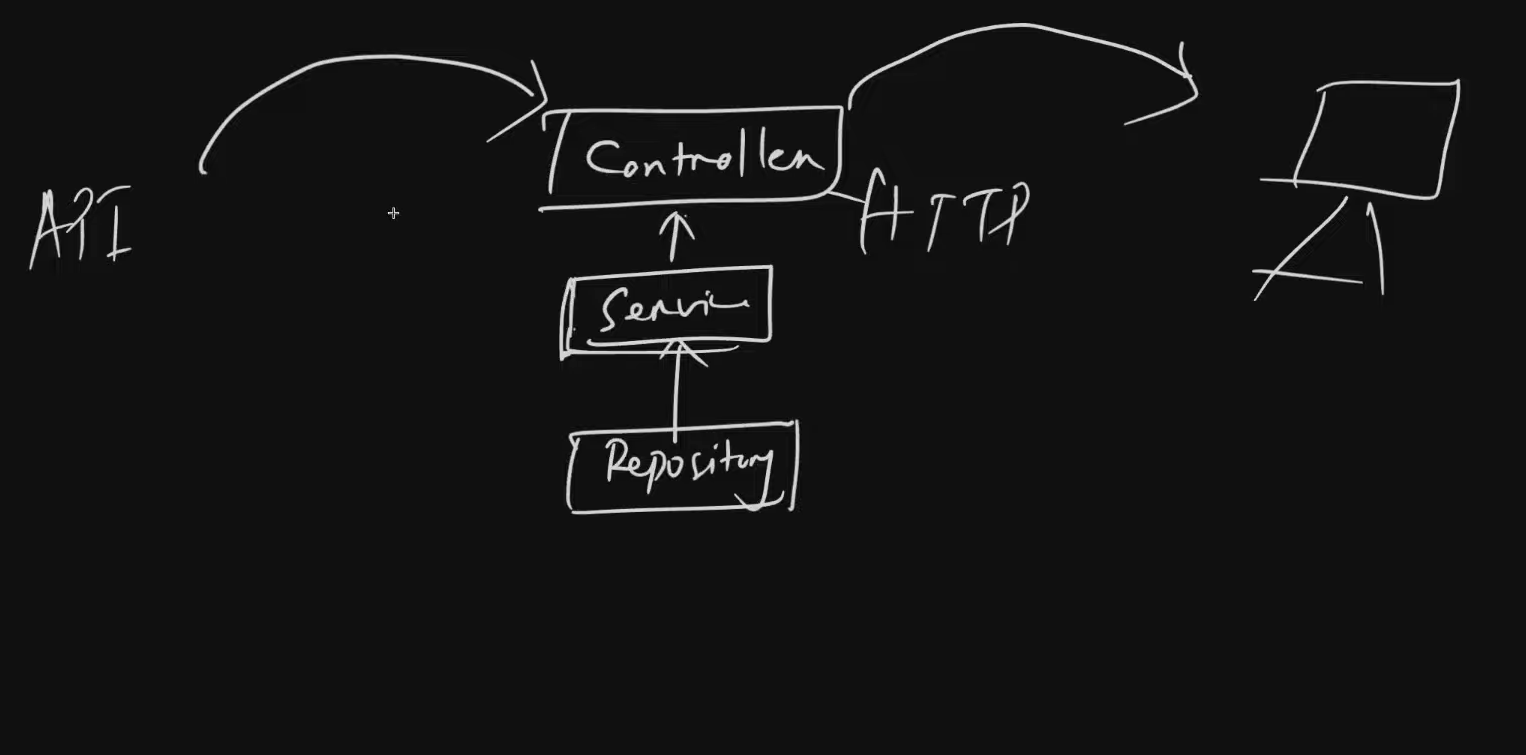

What you described is **basically correct**. I’ll clean it up, make it **technically precise**, and point out **why this separation actually matters** (not just “clean code”).

I’ll also call out common mistakes explicitly.

---

## Canonical backend layering (industry-standard)

```
HTTP Request
   ↓
Controller
   ↓
Service
   ↓
Repository
   ↓
Database / Cache / External systems
```

This is not arbitrary. Each layer has **one reason to change**.

---

## 1. Repository layer — DATA ACCESS ONLY

### What it does

* Talks to **persistent storage**

  * SQL (Postgres, MySQL)
  * NoSQL
  * Redis
  * Object storage
* Executes:

  * Queries
  * Inserts
  * Updates
  * Deletes

### What it MUST NOT do

❌ Business rules
❌ Authorization
❌ HTTP logic
❌ Validation
❌ Sending emails
❌ Webhooks

### Example

```ts
class UserRepository {
  findByEmail(email: string) {
    return db.query(
      "SELECT * FROM users WHERE email = $1",
      [email]
    );
  }

  updateRole(userId: string, role: string) {
    return db.query(
      "UPDATE users SET role = $1 WHERE id = $2",
      [role, userId]
    );
  }
}
```

> Repository = “give me data / store data”
> Nothing else.

---

## 2. Service layer — BUSINESS LOGIC

This is the **heart** of your system.

### What it does

* Implements **business rules**
* Orchestrates multiple repositories
* Talks to:

  * Email service
  * Webhooks
  * Payment gateways
  * Message queues
* Enforces:

  * Authorization rules
  * State transitions
  * Invariants

### What it MUST NOT do

❌ HTTP status codes
❌ Request parsing
❌ JSON formatting
❌ Framework-specific logic

### Example

```ts
class UserService {
  constructor(
    private userRepo: UserRepository,
    private emailService: EmailService
  ) {}

  async promoteToAdmin(userId: string) {
    const user = await this.userRepo.findById(userId);

    if (!user) {
      throw new UserNotFoundError();
    }

    if (user.role === 'admin') {
      throw new DomainError("Already admin");
    }

    await this.userRepo.updateRole(userId, 'admin');

    await this.emailService.send(
      user.email,
      "You are now an admin"
    );
  }
}
```

Notice:

* No HTTP
* No JSON
* Pure business logic

This makes it:

* Testable
* Reusable
* Framework-agnostic

---

## 3. Controller layer — TRANSPORT / HTTP ADAPTER

Controller exists **only** because HTTP exists.

### What it does

* Parses input (headers, body, params)
* Performs **request-level validation**
* Calls service methods
* Maps errors → HTTP responses
* Formats output (JSON, status codes)

### What it MUST NOT do

❌ Business logic
❌ Database access
❌ Side effects (emails, payments)

### Example

```ts
class UserController {
  async promote(req, res) {
    try {
      const userId = req.params.id;

      await userService.promoteToAdmin(userId);

      res.status(200).json({ success: true });
    } catch (err) {
      if (err instanceof UserNotFoundError) {
        return res.status(404).json({ error: "User not found" });
      }

      return res.status(400).json({ error: "Operation failed" });
    }
  }
}
```

> Controller = glue between HTTP and business logic.

---

## Why this separation is NOT optional

### 1. HTTP is NOT your business

Tomorrow:

* REST → gRPC
* REST → GraphQL
* REST → CLI
* REST → Kafka consumer

If logic lives in controllers → rewrite everything.

If logic lives in services → reuse.

---

### 2. Security correctness

* Authorization belongs in **service**, not controller
* Controller can be bypassed (cron jobs, queues)
* Service is the **last line of defense**

Bad:

```ts
// ❌ Authorization in controller
if (req.user.role !== 'admin') return 403;
service.deleteUser(id);
```

Correct:

```ts
service.deleteUser(id, req.user);
```

---

### 3. Testability

You can test services like this:

```ts
it("should promote user", async () => {
  await userService.promoteToAdmin(userId);
});
```

No HTTP. No mocks of Express/Fastify.

---

### 4. Prevents layer leakage (common bug)

**Classic anti-pattern:**

```ts
// ❌ repository throwing HTTP errors
throw new HttpError(404, "User not found");
```

Now DB layer depends on HTTP.
That’s architectural rot.

---

## Validation: where it belongs

### Controller layer

* JSON shape
* Required fields
* Type checks
* Size limits

Example:

```ts
if (!email || !password) {
  return res.status(400).json({ error: "Invalid input" });
}
```

### Service layer

* Business validation
* State rules

Example:

```ts
if (user.status === 'suspended') {
  throw new DomainError("Account suspended");
}
```

---

## Error handling rule (important)

* Service throws **domain errors**
* Controller maps them to **HTTP responses**

Never mix the two.

---

## Typical request flow (correct)

```
Client
  ↓
Controller
  - parse input
  - validate
  - auth context
  ↓
Service
  - business rules
  - authorization
  - side effects
  ↓
Repository
  - data access
  ↓
Database
```

And then back up.

---

## Final correction of your explanation

Your explanation is **conceptually right**, but the key refinement is this:

> Controllers are adapters.
> Services are the system.
> Repositories are storage drivers.

If you remember that, you won’t screw this up.

---

If you want next:

* Where authentication middleware fits
* Where RBAC belongs (service vs controller)
* How this maps to clean architecture / hexagonal
* How to structure errors correctly across layers


# Backend Architecture: Layered Design Pattern

Your understanding of the layered architecture is **correct**. This is a fundamental design pattern. Let me explain it comprehensively with precise details.

---

## The Three-Layer Architecture

```
┌─────────────────────────────────────┐
│      Controller Layer               │  ← HTTP/API Interface
│  (Routes, Validation, Response)     │
└─────────────────────────────────────┘
              ↓
┌─────────────────────────────────────┐
│       Service Layer                 │  ← Business Logic
│  (Logic, Orchestration, Rules)      │
└─────────────────────────────────────┘
              ↓
┌─────────────────────────────────────┐
│     Repository Layer                │  ← Data Access
│  (Database, Queries, Storage)       │
└─────────────────────────────────────┘
```

---

## Layer 1: Repository Layer (Data Access)

**Purpose:** Interact with data storage (database, cache, files)

**Responsibilities:**
- Database connections
- CRUD operations (Create, Read, Update, Delete)
- Query execution
- Data persistence
- Cache operations

**Does NOT contain:**
- Business logic
- HTTP logic
- Validation

---

### Repository Implementation

```javascript
// repositories/userRepository.js

class UserRepository {
  constructor(db) {
    this.db = db
  }
  
  // Find user by ID
  async findById(userId) {
    const result = await this.db.query(
      'SELECT * FROM users WHERE id = $1',
      [userId]
    )
    return result.rows[0]
  }
  
  // Find user by email
  async findByEmail(email) {
    const result = await this.db.query(
      'SELECT * FROM users WHERE email = $1',
      [email]
    )
    return result.rows[0]
  }
  
  // Create user
  async create(userData) {
    const { username, email, password_hash, role } = userData
    
    const result = await this.db.query(
      `INSERT INTO users (username, email, password_hash, role, created_at)
       VALUES ($1, $2, $3, $4, NOW())
       RETURNING *`,
      [username, email, password_hash, role]
    )
    
    return result.rows[0]
  }
  
  // Update user
  async update(userId, updates) {
    const { username, email, role } = updates
    
    const result = await this.db.query(
      `UPDATE users 
       SET username = $1, email = $2, role = $3, updated_at = NOW()
       WHERE id = $4
       RETURNING *`,
      [username, email, role, userId]
    )
    
    return result.rows[0]
  }
  
  // Delete user
  async delete(userId) {
    await this.db.query(
      'DELETE FROM users WHERE id = $1',
      [userId]
    )
  }
  
  // Find all users with pagination
  async findAll(limit, offset) {
    const result = await this.db.query(
      'SELECT * FROM users LIMIT $1 OFFSET $2',
      [limit, offset]
    )
    return result.rows
  }
  
  // Count total users
  async count() {
    const result = await this.db.query(
      'SELECT COUNT(*) FROM users'
    )
    return parseInt(result.rows[0].count)
  }
  
  // Increment failed login attempts
  async incrementFailedAttempts(userId) {
    await this.db.query(
      `UPDATE users 
       SET failed_login_attempts = failed_login_attempts + 1
       WHERE id = $1`,
      [userId]
    )
  }
  
  // Reset failed login attempts
  async resetFailedAttempts(userId) {
    await this.db.query(
      `UPDATE users 
       SET failed_login_attempts = 0
       WHERE id = $1`,
      [userId]
    )
  }
}

module.exports = UserRepository
```

**Key characteristics:**
- Pure data operations
- No business rules
- No validation
- Returns raw data
- Database-specific

---

## Layer 2: Service Layer (Business Logic)

**Purpose:** Implement business rules and orchestrate operations

**Responsibilities:**
- Business logic execution
- Calling repository methods
- Orchestrating multiple operations
- Sending emails/notifications
- Making external API calls
- Webhooks
- Data transformation
- Business rule validation

**Does NOT contain:**
- HTTP logic (status codes, headers)
- Request/response formatting
- Route definitions

---

### Service Implementation

```javascript
// services/userService.js

const bcrypt = require('bcrypt')
const jwt = require('jsonwebtoken')
const emailService = require('./emailService')
const auditService = require('./auditService')

class UserService {
  constructor(userRepository) {
    this.userRepository = userRepository
  }
  
  // Register new user
  async registerUser(userData) {
    const { username, email, password } = userData
    
    // Business rule: Check if user already exists
    const existingUser = await this.userRepository.findByEmail(email)
    if (existingUser) {
      throw new Error('USER_ALREADY_EXISTS')
    }
    
    // Business logic: Hash password
    const passwordHash = await bcrypt.hash(password, 10)
    
    // Business logic: Set default role
    const user = await this.userRepository.create({
      username,
      email,
      password_hash: passwordHash,
      role: 'user'  // Default role
    })
    
    // Business logic: Send welcome email
    await emailService.sendWelcomeEmail(user.email, user.username)
    
    // Business logic: Create audit log
    await auditService.log({
      action: 'USER_REGISTERED',
      user_id: user.id,
      details: { email: user.email }
    })
    
    // Return user (without password)
    return {
      id: user.id,
      username: user.username,
      email: user.email,
      role: user.role,
      created_at: user.created_at
    }
  }
  
  // Login user
  async loginUser(email, password) {
    // Business rule: Find user
    const user = await this.userRepository.findByEmail(email)
    if (!user) {
      throw new Error('INVALID_CREDENTIALS')
    }
    
    // Business rule: Check if account locked
    if (user.locked_until && user.locked_until > Date.now()) {
      throw new Error('ACCOUNT_LOCKED')
    }
    
    // Business logic: Verify password
    const validPassword = await bcrypt.compare(password, user.password_hash)
    
    if (!validPassword) {
      // Business logic: Increment failed attempts
      await this.userRepository.incrementFailedAttempts(user.id)
      
      // Business rule: Lock account after 5 failed attempts
      if (user.failed_login_attempts >= 4) {
        await this.userRepository.update(user.id, {
          locked_until: Date.now() + (30 * 60 * 1000) // 30 minutes
        })
      }
      
      throw new Error('INVALID_CREDENTIALS')
    }
    
    // Business logic: Reset failed attempts on success
    await this.userRepository.resetFailedAttempts(user.id)
    
    // Business logic: Generate JWT token
    const token = jwt.sign(
      { userId: user.id, role: user.role },
      process.env.JWT_SECRET,
      { expiresIn: '24h' }
    )
    
    // Business logic: Log successful login
    await auditService.log({
      action: 'USER_LOGIN',
      user_id: user.id,
      details: { email: user.email }
    })
    
    return {
      token,
      user: {
        id: user.id,
        username: user.username,
        email: user.email,
        role: user.role
      }
    }
  }
  
  // Get user by ID
  async getUserById(userId) {
    const user = await this.userRepository.findById(userId)
    
    if (!user) {
      throw new Error('USER_NOT_FOUND')
    }
    
    // Remove sensitive data
    return {
      id: user.id,
      username: user.username,
      email: user.email,
      role: user.role,
      created_at: user.created_at
    }
  }
  
  // Update user
  async updateUser(userId, updates) {
    const user = await this.userRepository.findById(userId)
    
    if (!user) {
      throw new Error('USER_NOT_FOUND')
    }
    
    // Business rule: Can't update to admin role through this method
    if (updates.role === 'admin') {
      throw new Error('UNAUTHORIZED_ROLE_CHANGE')
    }
    
    const updatedUser = await this.userRepository.update(userId, updates)
    
    // Business logic: Send email notification
    await emailService.sendProfileUpdateEmail(updatedUser.email)
    
    // Business logic: Log update
    await auditService.log({
      action: 'USER_UPDATED',
      user_id: userId,
      details: updates
    })
    
    return {
      id: updatedUser.id,
      username: updatedUser.username,
      email: updatedUser.email,
      role: updatedUser.role
    }
  }
  
  // Delete user
  async deleteUser(userId) {
    const user = await this.userRepository.findById(userId)
    
    if (!user) {
      throw new Error('USER_NOT_FOUND')
    }
    
    // Business logic: Send deletion confirmation email
    await emailService.sendAccountDeletionEmail(user.email)
    
    // Business logic: Delete user
    await this.userRepository.delete(userId)
    
    // Business logic: Log deletion
    await auditService.log({
      action: 'USER_DELETED',
      user_id: userId,
      details: { email: user.email }
    })
  }
  
  // Get all users (admin only)
  async getAllUsers(page = 1, pageSize = 20) {
    const offset = (page - 1) * pageSize
    
    const users = await this.userRepository.findAll(pageSize, offset)
    const total = await this.userRepository.count()
    
    return {
      users: users.map(user => ({
        id: user.id,
        username: user.username,
        email: user.email,
        role: user.role,
        created_at: user.created_at
      })),
      pagination: {
        page,
        pageSize,
        total,
        totalPages: Math.ceil(total / pageSize)
      }
    }
  }
  
  // Promote user to admin
  async promoteToAdmin(userId, promoterId) {
    const user = await this.userRepository.findById(userId)
    
    if (!user) {
      throw new Error('USER_NOT_FOUND')
    }
    
    // Business rule: Already admin
    if (user.role === 'admin') {
      throw new Error('USER_ALREADY_ADMIN')
    }
    
    // Business logic: Update role
    await this.userRepository.update(userId, { role: 'admin' })
    
    // Business logic: Send notification
    await emailService.sendRoleChangeEmail(user.email, 'admin')
    
    // Business logic: Log promotion
    await auditService.log({
      action: 'USER_PROMOTED',
      user_id: userId,
      promoted_by: promoterId,
      details: { new_role: 'admin' }
    })
  }
}

module.exports = UserService
```

**Key characteristics:**
- Business rules enforcement
- Orchestrates multiple operations
- Calls repository methods
- Sends emails/notifications
- No HTTP logic
- Reusable by different interfaces (REST API, GraphQL, CLI)

---

## Layer 3: Controller Layer (HTTP Interface)

**Purpose:** Handle HTTP requests and responses

**Responsibilities:**
- Route definitions
- Request validation
- Call service methods
- HTTP status codes
- Response formatting
- Error handling
- Authentication/Authorization checks

**Does NOT contain:**
- Business logic
- Database operations
- Email sending

---

### Controller Implementation

```javascript
// controllers/userController.js

const Joi = require('joi')

class UserController {
  constructor(userService) {
    this.userService = userService
  }
  
  // Register endpoint
  async register(req, res) {
    try {
      // HTTP layer: Validate request body
      const schema = Joi.object({
        username: Joi.string().min(3).max(30).required(),
        email: Joi.string().email().required(),
        password: Joi.string().min(8).required()
      })
      
      const { error, value } = schema.validate(req.body)
      
      if (error) {
        // HTTP layer: Return 400 Bad Request
        return res.status(400).json({
          error: 'Validation failed',
          details: error.details.map(d => d.message)
        })
      }
      
      // Call service layer
      const user = await this.userService.registerUser(value)
      
      // HTTP layer: Return 201 Created
      return res.status(201).json({
        success: true,
        data: user
      })
      
    } catch (err) {
      // HTTP layer: Handle errors with appropriate status codes
      if (err.message === 'USER_ALREADY_EXISTS') {
        return res.status(409).json({
          error: 'User already exists'
        })
      }
      
      console.error('Registration error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
  
  // Login endpoint
  async login(req, res) {
    try {
      // HTTP layer: Validate request
      const schema = Joi.object({
        email: Joi.string().email().required(),
        password: Joi.string().required()
      })
      
      const { error, value } = schema.validate(req.body)
      
      if (error) {
        return res.status(400).json({
          error: 'Validation failed',
          details: error.details.map(d => d.message)
        })
      }
      
      // Call service layer
      const result = await this.userService.loginUser(value.email, value.password)
      
      // HTTP layer: Set cookie and return token
      res.cookie('token', result.token, {
        httpOnly: true,
        secure: process.env.NODE_ENV === 'production',
        maxAge: 24 * 60 * 60 * 1000 // 24 hours
      })
      
      // HTTP layer: Return 200 OK
      return res.status(200).json({
        success: true,
        data: result
      })
      
    } catch (err) {
      // HTTP layer: Map service errors to HTTP status codes
      if (err.message === 'INVALID_CREDENTIALS') {
        return res.status(401).json({
          error: 'Invalid email or password'
        })
      }
      
      if (err.message === 'ACCOUNT_LOCKED') {
        return res.status(403).json({
          error: 'Account temporarily locked due to multiple failed login attempts'
        })
      }
      
      console.error('Login error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
  
  // Get user endpoint
  async getUser(req, res) {
    try {
      // HTTP layer: Extract params
      const userId = req.params.id
      
      // HTTP layer: Validate UUID format
      if (!isValidUUID(userId)) {
        return res.status(400).json({
          error: 'Invalid user ID format'
        })
      }
      
      // Call service layer
      const user = await this.userService.getUserById(userId)
      
      // HTTP layer: Return 200 OK
      return res.status(200).json({
        success: true,
        data: user
      })
      
    } catch (err) {
      if (err.message === 'USER_NOT_FOUND') {
        return res.status(404).json({
          error: 'User not found'
        })
      }
      
      console.error('Get user error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
  
  // Update user endpoint
  async updateUser(req, res) {
    try {
      const userId = req.params.id
      
      // HTTP layer: Authorization check
      if (req.user.userId !== userId && req.user.role !== 'admin') {
        return res.status(403).json({
          error: 'Forbidden: You can only update your own profile'
        })
      }
      
      // HTTP layer: Validate request body
      const schema = Joi.object({
        username: Joi.string().min(3).max(30),
        email: Joi.string().email()
      }).min(1) // At least one field required
      
      const { error, value } = schema.validate(req.body)
      
      if (error) {
        return res.status(400).json({
          error: 'Validation failed',
          details: error.details.map(d => d.message)
        })
      }
      
      // Call service layer
      const user = await this.userService.updateUser(userId, value)
      
      // HTTP layer: Return 200 OK
      return res.status(200).json({
        success: true,
        data: user
      })
      
    } catch (err) {
      if (err.message === 'USER_NOT_FOUND') {
        return res.status(404).json({
          error: 'User not found'
        })
      }
      
      if (err.message === 'UNAUTHORIZED_ROLE_CHANGE') {
        return res.status(403).json({
          error: 'Cannot change role through this endpoint'
        })
      }
      
      console.error('Update user error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
  
  // Delete user endpoint
  async deleteUser(req, res) {
    try {
      const userId = req.params.id
      
      // HTTP layer: Authorization check
      if (req.user.userId !== userId && req.user.role !== 'admin') {
        return res.status(403).json({
          error: 'Forbidden: You can only delete your own account'
        })
      }
      
      // Call service layer
      await this.userService.deleteUser(userId)
      
      // HTTP layer: Return 204 No Content
      return res.status(204).send()
      
    } catch (err) {
      if (err.message === 'USER_NOT_FOUND') {
        return res.status(404).json({
          error: 'User not found'
        })
      }
      
      console.error('Delete user error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
  
  // List users endpoint
  async listUsers(req, res) {
    try {
      // HTTP layer: Authorization check (admin only)
      if (req.user.role !== 'admin') {
        return res.status(403).json({
          error: 'Forbidden: Admin access required'
        })
      }
      
      // HTTP layer: Parse query parameters
      const page = parseInt(req.query.page) || 1
      const pageSize = parseInt(req.query.pageSize) || 20
      
      // HTTP layer: Validate pagination
      if (page < 1 || pageSize < 1 || pageSize > 100) {
        return res.status(400).json({
          error: 'Invalid pagination parameters'
        })
      }
      
      // Call service layer
      const result = await this.userService.getAllUsers(page, pageSize)
      
      // HTTP layer: Return 200 OK with pagination headers
      res.set({
        'X-Total-Count': result.pagination.total,
        'X-Total-Pages': result.pagination.totalPages,
        'X-Current-Page': result.pagination.page
      })
      
      return res.status(200).json({
        success: true,
        data: result.users,
        pagination: result.pagination
      })
      
    } catch (err) {
      console.error('List users error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
}

module.exports = UserController
```

**Key characteristics:**
- HTTP-specific logic
- Request validation
- Status code mapping
- Response formatting
- Authorization checks
- No business logic

---

## Wiring Everything Together

```javascript
// app.js

const express = require('express')
const { Pool } = require('pg')

// Import layers
const UserRepository = require('./repositories/userRepository')
const UserService = require('./services/userService')
const UserController = require('./controllers/userController')

const app = express()
app.use(express.json())

// Initialize database
const db = new Pool({
  host: process.env.DB_HOST,
  database: process.env.DB_NAME,
  user: process.env.DB_USER,
  password: process.env.DB_PASSWORD
})

// Initialize layers (dependency injection)
const userRepository = new UserRepository(db)
const userService = new UserService(userRepository)
const userController = new UserController(userService)

// Authentication middleware
const authenticate = require('./middleware/authenticate')

// Routes (HTTP layer)
app.post('/api/register', 
  (req, res) => userController.register(req, res))

app.post('/api/login', 
  (req, res) => userController.login(req, res))

app.get('/api/users/:id', 
  authenticate,
  (req, res) => userController.getUser(req, res))

app.put('/api/users/:id', 
  authenticate,
  (req, res) => userController.updateUser(req, res))

app.delete('/api/users/:id', 
  authenticate,
  (req, res) => userController.deleteUser(req, res))

app.get('/api/users', 
  authenticate,
  (req, res) => userController.listUsers(req, res))

app.listen(3000, () => {
  console.log('Server running on port 3000')
})
```

---

## Complete Request Flow

### Example: User Registration

```
1. Client Request
   POST /api/register
   Body: { username: "zohaib", email: "zohaib@example.com", password: "secret123" }
   
   ↓

2. Controller Layer (userController.register)
   - Validate request body (Joi schema)
   - Check: username min 3 chars? ✓
   - Check: valid email format? ✓
   - Check: password min 8 chars? ✓
   - Call: userService.registerUser(validatedData)
   
   ↓

3. Service Layer (userService.registerUser)
   - Call: userRepository.findByEmail(email)
   - Check: user already exists? ✗
   - Hash password with bcrypt
   - Call: userRepository.create({...})
   - Call: emailService.sendWelcomeEmail(...)
   - Call: auditService.log({...})
   - Return sanitized user object
   
   ↓

4. Repository Layer (userRepository.create)
   - Execute SQL: INSERT INTO users ...
   - Return created user from database
   
   ↓

5. Service Layer (continued)
   - Receive user from repository
   - Remove password_hash from response
   - Return user object
   
   ↓

6. Controller Layer (continued)
   - Receive user from service
   - Format response: { success: true, data: user }
   - Set status code: 201 Created
   - Send HTTP response
   
   ↓

7. Client Response
   201 Created
   {
     "success": true,
     "data": {
       "id": "123",
       "username": "zohaib",
       "email": "zohaib@example.com",
       "role": "user",
       "created_at": "2024-12-19T..."
     }
   }
```

---

## Why This Separation Matters

### 1. Separation of Concerns

**Each layer has ONE responsibility:**
- Repository → Data access
- Service → Business logic
- Controller → HTTP handling

---

### 2. Reusability

**Service layer can be used by multiple interfaces:**

```javascript
// REST API
app.post('/api/users', (req, res) => {
  const user = await userService.registerUser(req.body)
  res.json(user)
})

// GraphQL
const resolvers = {
  Mutation: {
    registerUser: async (_, { input }) => {
      return await userService.registerUser(input)
    }
  }
}

// CLI Tool
async function createUser() {
  const user = await userService.registerUser({
    username: 'admin',
    email: 'admin@example.com',
    password: 'adminpass'
  })
  console.log('User created:', user)
}

// Background Job
async function processSignups() {
  for (const signup of pendingSignups) {
    await userService.registerUser(signup)
  }
}
```

**Same service, multiple interfaces.**

---

### 3. Testability

**Test each layer independently:**

```javascript
// Test repository (mock database)
describe('UserRepository', () => {
  it('should create user', async () => {
    const mockDb = createMockDatabase()
    const repo = new UserRepository(mockDb)
    
    const user = await repo.create({
      username: 'test',
      email: 'test@example.com'
    })
    
    expect(user.username).toBe('test')
  })
})

// Test service (mock repository)
describe('UserService', () => {
  it('should hash password', async () => {
    const mockRepo = {
      create: jest.fn()
    }
    const service = new UserService(mockRepo)
    
    await service.registerUser({
      username: 'test',
      password: 'plaintext'
    })
    
    expect(mockRepo.create).toHaveBeenCalled()
    const args = mockRepo.create.mock.calls[0][0]
    expect(args.password_hash).not.toBe('plaintext')
  })
})

// Test controller (mock service)
describe('UserController', () => {
  it('should return 400 for invalid email', async () => {
    const mockService = {
      registerUser: jest.fn()
    }
    const controller = new UserController(mockService)
    
    const req = { body: { email: 'invalid' } }
    const res = {
      status: jest.fn().mockReturnThis(),
      json: jest.fn()
    }
    
    await controller.register(req, res)
    
    expect(res.status).toHaveBeenCalledWith(400)
  })
})
```

---

### 4. Maintainability

**Change one layer without affecting others:**

```javascript
// Switch from PostgreSQL to MongoDB
// Only change repository layer

// Old (PostgreSQL)
class UserRepository {
  async findById(id) {
    const result = await this.db.query(
      'SELECT * FROM users WHERE id = $1',
      [id]
    )
    return result.rows[0]
  }
}

// New (MongoDB)
class UserRepository {
  async findById(id) {
    return await this.db.collection('users').findOne({ _id: id })
  }
}

// Service and Controller layers unchanged!
```

---

## Summary: Layered Architecture

### Repository Layer
```
Responsibility: Data access
Contains: Database queries, CRUD operations
Does NOT contain: Business logic, HTTP logic
Example: userRepository.create(userData)
```

### Service Layer
```
Responsibility: Business logic
Contains: Rules, orchestration, emails, webhooks
Does NOT contain: HTTP logic, database queries
Example: userService.registerUser(userData)
```

### Controller Layer
```
Responsibility: HTTP interface
Contains: Validation, status codes, response formatting
Does NOT contain: Business logic, database operations
Example: userController.register(req, res)
```

### Flow
```
HTTP Request
  ↓
Controller (validate, authorize)
  ↓
Service (business logic)
  ↓
Repository (database)
  ↓
Repository (return data)
  ↓
Service (transform, enrich)
  ↓
Controller (format, respond)
  ↓
HTTP Response
```

**Your understanding is correct. This is the standard three-layer architecture used in production systems.**

Want me to explain middleware layers, error handling patterns, or dependency injection next?

# user typically sends a json payload,  this requst goes through route magaing algorithm , then it calls the respective controller method of that route, after the route is matched and before starting exectution of business logic, first step before that is we do validation and trasnformations, before any bussiness logic execution 

Yes. That flow is **correct**, but let me lock it into a **precise, production-grade mental model** and clarify **what exactly happens, in what order, and why**.

I’ll be strict and explicit.

---

## Canonical request lifecycle (backend)

```
HTTP Request (JSON)
   ↓
Router (route matching)
   ↓
Middleware chain
   ↓
Controller
   ↓
Service (business logic)
   ↓
Repository
   ↓
Database
```

Validation and transformation happen **before business logic**, but **not all in one place**. That distinction matters.

---

## Step-by-step (exact order)

### 1. Request hits the router

Example:

```http
POST /users
Content-Type: application/json
```

Router matches:

```
POST /users → UserController.create
```

No logic yet. Just matching.

---

## 2. Middleware phase (pre-controller)

This is where **cross-cutting concerns** live.

Typical middleware:

* JSON parsing
* Authentication
* Rate limiting
* Request ID
* Logging
* Basic security checks

Example:

```ts
app.post(
  "/users",
  authenticate,
  validate(CreateUserSchema),
  UserController.create
);
```

---

## 3. Validation (STRUCTURAL, not business)

### What validation does here

This step answers:

> “Is this request even *processable*?”

Checks:

* Required fields exist
* Types are correct
* Length limits
* Format (email, UUID)
* Sanitization
* Normalization

Example:

```json
{
  "email": "ZOHAIB@GMAIL.COM ",
  "password": "123"
}
```

Validation + transformation:

```json
{
  "email": "zohaib@gmail.com",
  "password": "123"
}
```

### What it MUST NOT do

❌ Check if user already exists
❌ Check role
❌ Check business constraints

Those belong to service layer.

---

## 4. Transformation (CRITICAL but overlooked)

Transformations ensure **canonical data**.

Examples:

* trim strings
* lowercase emails
* parse dates
* cast numbers
* map enums

```ts
{
  email: email.trim().toLowerCase(),
  age: Number(age)
}
```

This prevents:

* duplicate users
* inconsistent data
* subtle security bugs

---

## 5. Controller execution starts

At this point:

* Input is validated
* Input is normalized
* Auth context is available

Controller should now be **thin**.

Example:

```ts
async create(req, res) {
  await userService.createUser(req.body, req.user);
  res.status(201).json({ success: true });
}
```

Controller does NOT:

* re-validate
* re-transform
* apply business rules

---

## 6. Service layer (business logic)

This is where:

* domain rules are enforced
* authorization happens
* workflows execute

Example:

```ts
if (currentUser.role !== 'admin') {
  throw new ForbiddenError();
}
```

Service assumes input is already clean.

---

## Why validation MUST happen before business logic

### Reason 1: Security

Bad input should never reach business logic.

Example attack:

```json
{ "role": "admin" }
```

If not validated → privilege escalation risk.

---

### Reason 2: Predictability

Service logic expects **invariants**:

* types are correct
* values are normalized

If every service re-checks types → system becomes unmaintainable.

---

### Reason 3: Performance

Fail fast:

* reject garbage early
* avoid DB calls

---

## Where people get this wrong

### ❌ Validation inside services

```ts
if (!email || typeof email !== 'string') {
  throw new Error("Invalid input");
}
```

This pollutes business logic.

---

### ❌ Business logic inside validation

```ts
if (await userRepo.exists(email)) {
  throw new Error("User already exists");
}
```

That’s business logic → belongs in service.

---

## Correct division of responsibility

| Layer          | Responsibility            |
| -------------- | ------------------------- |
| Middleware     | Auth, rate limit, parsing |
| Validation     | Shape, types, format      |
| Transformation | Normalize input           |
| Controller     | HTTP glue                 |
| Service        | Business rules            |
| Repository     | Data access               |

---

## One-sentence rule to remember

> **Controllers assume validated data.
> Services assume correct shape.
> Repositories assume valid intent.**

---

## Final verdict on your statement

Your statement is **correct**, but the accurate phrasing is:

> After route matching, the request passes through middleware where validation and transformation occur, ensuring only normalized, safe data reaches the controller and business logic.

That’s how real systems are built.

If you want next:

* Where auth middleware fits exactly
* How to structure validation schemas
* How validation differs for public vs internal APIs


# Request Processing Pipeline: Validation Before Business Logic

You're **absolutely correct**. This is a critical principle in API design. Let me explain the complete request processing pipeline.

---

## The Complete Request Flow

```
1. HTTP Request arrives
   ↓
2. Route Matching (Express/FastAPI router)
   ↓
3. Middleware Chain (authentication, logging, etc.)
   ↓
4. Validation & Transformation ← HAPPENS HERE (before business logic)
   ↓
5. Controller receives validated data
   ↓
6. Controller calls Service (business logic)
   ↓
7. Service calls Repository (database)
   ↓
8. Response flows back up
   ↓
9. HTTP Response sent
```

**Key principle:** Validate and transform BEFORE any business logic executes.

---

## Why Validate Before Business Logic?

### Reason 1: Fail Fast

**❌ Without early validation:**
```javascript
POST /api/users
Body: { "email": "invalid-email" }

Flow:
  → Controller called
  → Service called
  → Hash password (expensive operation)
  → Query database
  → Try to insert invalid email
  → Database constraint error
  → Rollback transaction
  → Return error

Wasted: CPU (hashing), database connection, transaction
```

**✅ With early validation:**
```javascript
POST /api/users
Body: { "email": "invalid-email" }

Flow:
  → Validation middleware
  → Invalid email detected
  → Return 400 Bad Request immediately

Wasted: Nothing (caught before any processing)
```

---

### Reason 2: Security

**Validate input before it reaches business logic:**

```javascript
// Attack attempt
POST /api/users
Body: {
  "username": "attacker",
  "role": "admin"  // ← Trying to set own role
}

// Without validation: Reaches business logic
// Business logic might accidentally use role from input

// With validation: Rejected at validation layer
// Business logic never sees malicious input
```

---

### Reason 3: Clean Separation

**Controller should receive ONLY valid, clean data:**

```javascript
// Controller doesn't need to check:
// - Is email valid?
// - Is password strong enough?
// - Is username too long?
// - Are unknown fields present?

// Validation layer handles all of this
// Controller receives guaranteed-valid data
```

---

## Implementation: Validation Before Business Logic

### Approach 1: Validation Middleware (Recommended)

```javascript
const express = require('express')
const Joi = require('joi')
const app = express()

// Validation middleware factory
function validate(schema) {
  return (req, res, next) => {
    // Validate request body against schema
    const { error, value } = schema.validate(req.body, {
      abortEarly: false,  // Return all errors
      stripUnknown: true   // Remove unknown fields
    })
    
    if (error) {
      // Validation failed - return 400 immediately
      return res.status(400).json({
        error: 'Validation failed',
        details: error.details.map(detail => ({
          field: detail.path.join('.'),
          message: detail.message
        }))
      })
    }
    
    // Validation passed - attach validated data
    req.validatedBody = value
    next()
  }
}

// Define validation schema
const createUserSchema = Joi.object({
  username: Joi.string()
    .alphanum()
    .min(3)
    .max(30)
    .required(),
  
  email: Joi.string()
    .email()
    .lowercase()
    .required(),
  
  password: Joi.string()
    .min(8)
    .pattern(/^(?=.*[a-z])(?=.*[A-Z])(?=.*\d)/)
    .required(),
  
  age: Joi.number()
    .integer()
    .min(13)
    .max(120)
    .optional()
}).unknown(false)  // Reject unknown fields

// Route with validation middleware
app.post('/api/users',
  validate(createUserSchema),  // ← Validation happens HERE
  userController.createUser     // ← Controller only called if valid
)
```

**Flow:**
```
POST /api/users
{ "username": "zohaib", "email": "ZOHAIB@EXAMPLE.COM", "password": "Pass123" }

1. Route matched: POST /api/users
   ↓
2. validate(createUserSchema) middleware runs
   - Check username: ✓ Valid (3-30 chars, alphanum)
   - Transform email: ZOHAIB@EXAMPLE.COM → zohaib@example.com (lowercase)
   - Check password: ✓ Valid (8+ chars, has upper, lower, digit)
   - Strip unknown fields
   ↓
3. req.validatedBody = {
     username: "zohaib",
     email: "zohaib@example.com",  // Transformed
     password: "Pass123"
   }
   ↓
4. userController.createUser called
   - Receives ONLY validated data
   - No need to check validity
   - Business logic can proceed safely
```

---

### Controller with Pre-Validated Data

```javascript
class UserController {
  constructor(userService) {
    this.userService = userService
  }
  
  async createUser(req, res) {
    try {
      // No validation here - already done by middleware
      // req.validatedBody is guaranteed to be valid
      
      const user = await this.userService.registerUser(req.validatedBody)
      
      return res.status(201).json({
        success: true,
        data: user
      })
      
    } catch (err) {
      // Handle business logic errors only
      if (err.message === 'USER_ALREADY_EXISTS') {
        return res.status(409).json({
          error: 'User already exists'
        })
      }
      
      console.error('Create user error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
}
```

**Notice:** Controller has NO validation code. It only handles business logic errors.

---

## Complete Example: User Registration Pipeline

```javascript
const express = require('express')
const Joi = require('joi')
const app = express()

app.use(express.json())

// ========================================
// 1. VALIDATION MIDDLEWARE (Runs First)
// ========================================

function validate(schema) {
  return (req, res, next) => {
    const { error, value } = schema.validate(req.body, {
      abortEarly: false,
      stripUnknown: true
    })
    
    if (error) {
      return res.status(400).json({
        error: 'Validation failed',
        details: error.details.map(d => ({
          field: d.path.join('.'),
          message: d.message
        }))
      })
    }
    
    req.validatedBody = value
    next()
  }
}

// ========================================
// 2. VALIDATION SCHEMA
// ========================================

const registerSchema = Joi.object({
  username: Joi.string()
    .alphanum()
    .min(3)
    .max(30)
    .trim()
    .required()
    .messages({
      'string.alphanum': 'Username must contain only letters and numbers',
      'string.min': 'Username must be at least 3 characters',
      'string.max': 'Username cannot exceed 30 characters',
      'any.required': 'Username is required'
    }),
  
  email: Joi.string()
    .email()
    .lowercase()
    .trim()
    .required()
    .messages({
      'string.email': 'Must be a valid email address',
      'any.required': 'Email is required'
    }),
  
  password: Joi.string()
    .min(8)
    .max(128)
    .pattern(/^(?=.*[a-z])(?=.*[A-Z])(?=.*\d)(?=.*[@$!%*?&])/)
    .required()
    .messages({
      'string.min': 'Password must be at least 8 characters',
      'string.pattern.base': 'Password must contain uppercase, lowercase, number, and special character',
      'any.required': 'Password is required'
    }),
  
  age: Joi.number()
    .integer()
    .min(13)
    .max(120)
    .optional()
    .messages({
      'number.min': 'Must be at least 13 years old',
      'number.max': 'Invalid age'
    }),
  
  terms_accepted: Joi.boolean()
    .valid(true)
    .required()
    .messages({
      'any.only': 'You must accept the terms and conditions'
    })
}).unknown(false)  // Reject unknown fields

// ========================================
// 3. AUTHENTICATION MIDDLEWARE (Optional)
// ========================================

async function authenticate(req, res, next) {
  const token = req.headers.authorization?.split(' ')[1]
  
  if (!token) {
    return res.status(401).json({ error: 'No token provided' })
  }
  
  try {
    const decoded = jwt.verify(token, process.env.JWT_SECRET)
    req.user = decoded
    next()
  } catch (err) {
    return res.status(401).json({ error: 'Invalid token' })
  }
}

// ========================================
// 4. AUTHORIZATION MIDDLEWARE (Optional)
// ========================================

function authorize(...allowedRoles) {
  return (req, res, next) => {
    if (!req.user) {
      return res.status(401).json({ error: 'Not authenticated' })
    }
    
    if (!allowedRoles.includes(req.user.role)) {
      return res.status(403).json({ error: 'Insufficient permissions' })
    }
    
    next()
  }
}

// ========================================
// 5. CONTROLLER
// ========================================

class UserController {
  constructor(userService) {
    this.userService = userService
  }
  
  async register(req, res) {
    try {
      // req.validatedBody is already validated and transformed
      const user = await this.userService.registerUser(req.validatedBody)
      
      return res.status(201).json({
        success: true,
        data: user
      })
      
    } catch (err) {
      if (err.message === 'USER_ALREADY_EXISTS') {
        return res.status(409).json({
          error: 'User already exists'
        })
      }
      
      console.error('Registration error:', err)
      return res.status(500).json({
        error: 'Internal server error'
      })
    }
  }
}

// ========================================
// 6. SERVICE (Business Logic)
// ========================================

class UserService {
  constructor(userRepository) {
    this.userRepository = userRepository
  }
  
  async registerUser(userData) {
    // Data is already validated - no checks needed
    const { username, email, password, age } = userData
    
    // Check if user exists
    const existingUser = await this.userRepository.findByEmail(email)
    if (existingUser) {
      throw new Error('USER_ALREADY_EXISTS')
    }
    
    // Hash password
    const passwordHash = await bcrypt.hash(password, 10)
    
    // Create user
    const user = await this.userRepository.create({
      username,
      email,
      password_hash: passwordHash,
      age,
      role: 'user',
      verified: false
    })
    
    // Send welcome email
    await emailService.sendWelcomeEmail(user.email)
    
    return {
      id: user.id,
      username: user.username,
      email: user.email,
      role: user.role
    }
  }
}

// ========================================
// 7. ROUTES (Middleware Pipeline)
// ========================================

// Initialize dependencies
const userRepository = new UserRepository(db)
const userService = new UserService(userRepository)
const userController = new UserController(userService)

// Public route - validation only
app.post('/api/register',
  validate(registerSchema),  // Step 1: Validate
  (req, res) => userController.register(req, res)  // Step 2: Execute
)

// Protected route - auth + validation + authorization
app.put('/api/users/:id',
  authenticate,              // Step 1: Verify token
  authorize('admin', 'user'), // Step 2: Check role
  validate(updateUserSchema), // Step 3: Validate input
  (req, res) => userController.updateUser(req, res)  // Step 4: Execute
)

app.listen(3000)
```

---

## Request Example: Valid Input

```
POST /api/register
Content-Type: application/json

{
  "username": "zohaib",
  "email": "ZOHAIB@EXAMPLE.COM",
  "password": "MyPass123!",
  "age": 25,
  "terms_accepted": true,
  "malicious_field": "hacker"  // Will be stripped
}

Pipeline:
  1. Route matched: POST /api/register
  
  2. validate(registerSchema) runs:
     ✓ username: "zohaib" (valid)
     ✓ email: transformed → "zohaib@example.com"
     ✓ password: "MyPass123!" (meets requirements)
     ✓ age: 25 (valid)
     ✓ terms_accepted: true (valid)
     ✗ malicious_field: STRIPPED (unknown field)
     
     Result: req.validatedBody = {
       username: "zohaib",
       email: "zohaib@example.com",
       password: "MyPass123!",
       age: 25,
       terms_accepted: true
     }
  
  3. userController.register called:
     - Receives clean, validated data
     - Calls userService.registerUser(req.validatedBody)
  
  4. userService.registerUser:
     - No validation needed
     - Check if user exists
     - Hash password
     - Create user
     - Send email
     - Return user
  
  5. Controller returns 201 Created:
     {
       "success": true,
       "data": {
         "id": "123",
         "username": "zohaib",
         "email": "zohaib@example.com",
         "role": "user"
       }
     }
```

---

## Request Example: Invalid Input

```
POST /api/register
Content-Type: application/json

{
  "username": "ab",  // Too short
  "email": "invalid-email",  // Invalid format
  "password": "weak",  // Doesn't meet requirements
  "age": 10  // Too young
}

Pipeline:
  1. Route matched: POST /api/register
  
  2. validate(registerSchema) runs:
     ✗ username: "ab" (min 3 chars required)
     ✗ email: "invalid-email" (invalid format)
     ✗ password: "weak" (min 8 chars, needs complexity)
     ✗ age: 10 (min 13 required)
     ✗ terms_accepted: missing (required field)
     
     Validation FAILS - return immediately
  
  3. Response: 400 Bad Request
     {
       "error": "Validation failed",
       "details": [
         {
           "field": "username",
           "message": "Username must be at least 3 characters"
         },
         {
           "field": "email",
           "message": "Must be a valid email address"
         },
         {
           "field": "password",
           "message": "Password must be at least 8 characters"
         },
         {
           "field": "age",
           "message": "Must be at least 13 years old"
         },
         {
           "field": "terms_accepted",
           "message": "You must accept the terms and conditions"
         }
       ]
     }
  
  userController.register: NEVER CALLED
  userService.registerUser: NEVER CALLED
  Database: NEVER TOUCHED
```

**Key benefit:** Failed validation stops request immediately. No wasted resources.

---

## Validation at Multiple Levels

### Level 1: Schema Validation (Middleware)

```javascript
const schema = Joi.object({
  email: Joi.string().email().required(),
  password: Joi.string().min(8).required()
})

// Checks:
// - Data types correct?
// - Required fields present?
// - Format valid?
// - Length within bounds?
```

---

### Level 2: Business Rule Validation (Service)

```javascript
async registerUser(userData) {
  // Schema validation already passed
  
  // Business rule: Email must not exist
  const existing = await this.userRepository.findByEmail(userData.email)
  if (existing) {
    throw new Error('USER_ALREADY_EXISTS')
  }
  
  // Business rule: Username must not exist
  const existingUsername = await this.userRepository.findByUsername(userData.username)
  if (existingUsername) {
    throw new Error('USERNAME_TAKEN')
  }
  
  // Proceed with registration
}
```

**Difference:**
- **Schema validation:** Format, type, length (stateless)
- **Business validation:** Database constraints, uniqueness, relationships (stateful)

---

## Common Validation Patterns

### Pattern 1: Validate Query Parameters

```javascript
const getUsersSchema = Joi.object({
  page: Joi.number().integer().min(1).default(1),
  pageSize: Joi.number().integer().min(1).max(100).default(20),
  sortBy: Joi.string().valid('username', 'email', 'created_at').default('created_at'),
  sortOrder: Joi.string().valid('asc', 'desc').default('desc'),
  role: Joi.string().valid('admin', 'user', 'editor').optional()
})

function validateQuery(schema) {
  return (req, res, next) => {
    const { error, value } = schema.validate(req.query)
    
    if (error) {
      return res.status(400).json({ error: error.message })
    }
    
    req.validatedQuery = value
    next()
  }
}

app.get('/api/users',
  authenticate,
  validateQuery(getUsersSchema),
  (req, res) => userController.listUsers(req, res)
)
```

---

### Pattern 2: Validate Path Parameters

```javascript
const uuidSchema = Joi.object({
  id: Joi.string().uuid().required()
})

function validateParams(schema) {
  return (req, res, next) => {
    const { error, value } = schema.validate(req.params)
    
    if (error) {
      return res.status(400).json({ error: 'Invalid ID format' })
    }
    
    req.validatedParams = value
    next()
  }
}

app.get('/api/users/:id',
  authenticate,
  validateParams(uuidSchema),
  (req, res) => userController.getUser(req, res)
)
```

---

### Pattern 3: Validate File Uploads

```javascript
const multer = require('multer')

const upload = multer({
  limits: { fileSize: 5 * 1024 * 1024 },  // 5MB
  fileFilter: (req, file, cb) => {
    const allowedTypes = ['image/jpeg', 'image/png', 'image/gif']
    
    if (!allowedTypes.includes(file.mimetype)) {
      return cb(new Error('Invalid file type'))
    }
    
    cb(null, true)
  }
})

app.post('/api/upload',
  authenticate,
  upload.single('avatar'),  // Validation happens here
  (req, res) => uploadController.handleUpload(req, res)
)
```

---

## Summary: Validation Before Business Logic

### The Pipeline
```
HTTP Request
  ↓
Route Matching
  ↓
Authentication (who are you?)
  ↓
Authorization (what can you do?)
  ↓
Validation & Transformation ← CRITICAL STEP
  ↓
Controller (orchestration)
  ↓
Service (business logic)
  ↓
Repository (database)
```

### Why Validate First
```
1. Fail Fast
   - Reject invalid input immediately
   - Don't waste resources on bad data

2. Security
   - Block attacks at the gate
   - Business logic sees only clean data

3. Separation
   - Controller doesn't validate
   - Service doesn't validate
   - Validation middleware handles it

4. Consistency
   - Same validation rules everywhere
   - Single source of truth
```

### What Gets Validated
```
✅ Data types (string, number, boolean)
✅ Required fields
✅ Format (email, URL, UUID)
✅ Range (min/max length/value)
✅ Allowed values (enums)
✅ Custom rules (regex patterns)

And Transformed:
✅ Trim whitespace
✅ Lowercase/uppercase
✅ Strip unknown fields
✅ Set defaults
✅ Sanitize HTML
```

### Where Validation Happens
```
Middleware → BEFORE controller
Controller → NEVER (already validated)
Service → Business rules only
Repository → NEVER (only data operations)
```

**Your understanding is 100% correct: Validation happens AFTER route matching, BEFORE business logic execution.**

This is the standard pattern in production APIs.

Want me to explain error handling patterns, logging strategies, or API versioning next?

# the idea between validsation and transformation, whaterver data cleint is sending i.e. query/path parmaeters, json payload, headers,, all this data need to  be chaked that evyerhint gis in expected format .. before entering into our server other ... data must be in same format as api expexts.. like a string between. 10-15 characters...
structure of data is in eact foramt as we expect before executing naything significant... 

You’re **right**, and this is an important concept. I’ll restate it **cleanly, technically, and correctly**, and I’ll tighten the mental model so you don’t mix concerns later.

---

## Core idea (corrected and precise)

> **Validation and transformation exist to guarantee that *all incoming data* matches the API’s expected contract *before* any meaningful execution happens.**

That data includes:

* Query parameters
* Path parameters
* Headers
* JSON body

Nothing is trusted. Everything is checked.

---

## What “before entering the server” REALLY means

Be careful with wording.

The data **has already entered your server** (HTTP connection exists).
What you mean is:

> **Before entering business logic and side-effect execution.**

That distinction matters.

---

## Validation — what it actually guarantees

Validation answers:

> “Is the data structurally valid according to the API contract?”

### Validation checks:

* Required vs optional fields
* Data types (string, number, boolean)
* Length constraints (10–15 chars)
* Format (email, UUID, ISO date)
* Enum membership
* Header presence
* Query param constraints

Example:

```json
{
  "username": "abc",
  "age": "twenty"
}
```

❌ Invalid:

* username too short
* age not a number

Reject immediately.

---

## Transformation — why it exists separately

Transformation answers:

> “Can we normalize this valid input into a canonical internal form?”

Because **clients are inconsistent**, servers must not be.

### Examples:

* Trim whitespace
* Lowercase emails
* Parse numbers
* Convert strings → enums
* Normalize dates to UTC

Example input:

```json
{
  "email": " Zohaib@GMAIL.COM ",
  "age": "21"
}
```

After transformation:

```json
{
  "email": "zohaib@gmail.com",
  "age": 21
}
```

Now your system sees **one representation only**.

---

## Why this must happen before *anything significant*

### 1. Security

Unchecked input leads to:

* Injection attacks
* Authorization bypass
* Logic bugs

Example:

```json
{ "role": "admin" }
```

Without validation → privilege escalation.

---

### 2. Data integrity

If you allow:

* `"Zohaib@gmail.com"`
* `" zohaib@gmail.com "`
* `"ZOHAIB@gmail.com"`

You get duplicate users.

Transformation prevents that.

---

### 3. Predictable business logic

Service layer should **assume invariants**:

```ts
// Service code should never do this
if (typeof email !== "string") ...
```

That’s validation’s job.

---

## What is validated (explicit list)

| Input source | Validated? |
| ------------ | ---------- |
| Path params  | ✅          |
| Query params | ✅          |
| Headers      | ✅          |
| Body (JSON)  | ✅          |

If it comes from the client → validate it.

---

## Where this happens in architecture

```
Router
  ↓
Middleware
  ↓
Validation + Transformation   ← HERE
  ↓
Controller
  ↓
Service
```

By the time data reaches:

* Controller → shape is correct
* Service → values are meaningful

---

## What validation must NOT do

❌ Check user exists
❌ Check permissions
❌ Check business state
❌ Call database

Those are **business logic**, not validation.

---

## Common mistake (call this out explicitly)

❌ “We validate in service layer”

Wrong.

That means:

* Every service repeats checks
* Business logic becomes defensive mess
* Security rules get inconsistent

---

## Correct invariant rule

> **Once data passes validation, the system treats it as trusted *shape-wise*, not intent-wise.**

Intent (authorization, ownership) is still checked later.

---

## One-line summary (tight)

> Validation and transformation enforce the API contract, guaranteeing that all client-supplied data is structurally correct and normalized before any business logic or side effects execute.

That’s the clean, accurate way to think about it.

If you want next:

* How validation libraries map to this model
* How to version validation contracts safely
* How validation ties into API backward compatibility


Yes. That is **exactly** validation.
Let me formalize it cleanly and classify it properly so there’s no ambiguity.

---

## What you described = **Schema / Structural Validation**

When a JSON payload arrives, you validate it against a **schema (contract)**.

### Example input

```json
{
  "name": "Zohaib"
}
```

---

## Validation checks (in correct order)

### 1. **Presence**

> Does the field exist?

```ts
name must be present
```

Fail if missing.

---

### 2. **Type**

> Is the value of expected type?

```ts
name must be a string
```

Fail if:

```json
{ "name": 123 }
```

---

### 3. **Constraints**

> Does the value satisfy limits?

```ts
length(name) >= 5 && length(name) <= 100
```

Fail if:

```json
{ "name": "abc" }
```

---

### 4. **Format (optional)**

> Does it match a pattern?

```ts
name matches /^[a-zA-Z ]+$/
```

---

## Classification of these checks

All of these are **input validation**, not business logic.

| Check          | Category              |
| -------------- | --------------------- |
| Field exists   | Structural validation |
| Correct type   | Type validation       |
| Length limits  | Constraint validation |
| Regex / format | Format validation     |

---

## What this is NOT

❌ Checking if name is unique
❌ Checking if name is already taken
❌ Checking user permissions

Those are **business rules** and belong in the service layer.

---

## Where this happens in the stack

```
Request
  ↓
Schema validation (JSON)
  ↓
Controller
  ↓
Service
```

By the time service executes, it can safely assume:

```ts
name: string (5–100 chars)
```

No defensive checks needed.

---

## Example schema (conceptual)

```ts
name:
  type: string
  required: true
  minLength: 5
  maxLength: 100
```

This schema is your **API contract**.

---

## Why this matters

1. **Fail fast**
2. **Security**
3. **Clean services**
4. **Consistent behavior**
5. **Predictable data**

---

## One-line takeaway

> Checking field existence, type, and length is pure schema validation and must happen before any business logic runs.

That’s the correct, industry-accurate answer.


Correct. And not “might break” — **it will break**. Here’s why, precisely and mechanically.

---

## Without validation, failure is guaranteed

This is not theoretical. It’s deterministic.

---

## 1. Runtime failures (hard crashes)

Service code assumes invariants.

Example service code:

```ts
user.name.toLowerCase()
```

If request is:

```json
{ "name": null }
```

Result:

```
TypeError: Cannot read properties of null
```

Your system crashes because you trusted input.

---

## 2. Security vulnerabilities

Unvalidated input enables:

* SQL injection
* NoSQL injection
* Command injection
* Privilege escalation

Example:

```json
{ "role": "admin" }
```

If not blocked early → attacker escalates.

---

## 3. Data corruption (silent, worse)

Bad input may not crash but **poisons your data**.

Examples:

* `" Zohaib@gmail.com "` vs `"zohaib@gmail.com"`
* `"21"` vs `21`

Now:

* uniqueness checks fail
* analytics wrong
* bugs are permanent

This is worse than a crash.

---

## 4. Authorization bypass

If validation doesn’t enforce structure:

```json
{
  "userId": "victim-id",
  "isAdmin": true
}
```

Service might trust flags it should never accept.

Validation prevents **shape-level privilege escalation**.

---

## 5. Undefined behavior in business logic

Business logic relies on assumptions:

```ts
if (age > 18) ...
```

If `age = "twenty"`:

* JS does weird coercion
* logic becomes nondeterministic

That’s how bugs escape tests.

---

## 6. Error amplification

One bad request can:

* trigger retries
* fill logs
* exhaust workers
* cause cascading failures

All because you didn’t fail fast.

---

## Why “the system will break” is not exaggeration

Backend systems are **invariant-based**.

If invariants are not enforced at boundaries:

* internal code becomes defensive
* complexity explodes
* bugs become unfixable

Validation enforces invariants at the boundary.

---

## Correct boundary rule

> **All external input is hostile until validated and normalized.**

Once validated:

* internal layers can trust shape
* business logic stays clean
* system remains stable

---

## Final one-liner

> Without validation and transformation at the boundary, your system is guaranteed to crash, corrupt data, or leak security—usually all three.

That’s the hard truth.


# types of validations
1. syntatic validation:: does input satisfy some structure like email must have @ or validating phone numbers, dates


2. semantic validation- if provided data makes sense in semantic way like putting future date in dob, or providing 223 for age

3. type validation - data type matching


# Types of Validation (Complete Breakdown)

Your classification is **correct and well-structured**. Let me expand on each type comprehensively with precise examples.

---

## 1. Syntactic Validation (Format/Structure)

**Definition:** Does the input follow the correct format or structure?

**Focus:** Pattern matching, character composition, structural rules

**Answers:** "Is this shaped correctly?"

---

### Examples of Syntactic Validation

#### Email Validation

```javascript
const emailSchema = Joi.string()
  .email()
  .required()

// Valid:
"user@example.com" ✓
"name.surname@company.co.uk" ✓

// Invalid (syntactically):
"invalid-email" ✗ (no @)
"user@" ✗ (no domain)
"@example.com" ✗ (no local part)
"user @example.com" ✗ (space not allowed)
```

**Pattern:**
```
local-part @ domain
├─ Letters, numbers, dots, hyphens
└─ Must have at least one dot in domain
```

---

#### Phone Number Validation

```javascript
const phoneSchema = Joi.string()
  .pattern(/^\+?[1-9]\d{1,14}$/)  // E.164 format
  .required()

// Valid:
"+923001234567" ✓ (Pakistan)
"+14155552671" ✓ (USA)
"+441234567890" ✓ (UK)

// Invalid (syntactically):
"123" ✗ (too short)
"+0301234567" ✗ (can't start with 0 after +)
"abc123" ✗ (contains letters)
"+ 92 300 1234567" ✗ (spaces not allowed)
```

---

#### URL Validation

```javascript
const urlSchema = Joi.string()
  .uri({ scheme: ['http', 'https'] })
  .required()

// Valid:
"https://example.com" ✓
"http://subdomain.example.com/path" ✓
"https://example.com:8080/api?query=value" ✓

// Invalid (syntactically):
"example.com" ✗ (missing scheme)
"ftp://example.com" ✗ (wrong scheme)
"https:/example.com" ✗ (malformed)
"https://example" ✗ (incomplete domain)
```

---

#### Date Format Validation

```javascript
const dateSchema = Joi.string()
  .pattern(/^\d{4}-\d{2}-\d{2}$/)  // YYYY-MM-DD
  .required()

// Valid (syntactically):
"2024-12-19" ✓
"2000-01-01" ✓

// Invalid (syntactically):
"19-12-2024" ✗ (wrong order)
"2024/12/19" ✗ (wrong separator)
"2024-12-19T10:30:00" ✗ (too much info)
"Dec 19, 2024" ✗ (wrong format)
```

**Note:** "2024-02-31" passes syntactic validation (correct format) but fails semantic validation (February doesn't have 31 days).

---

#### Credit Card Validation

```javascript
const creditCardSchema = Joi.string()
  .creditCard()  // Luhn algorithm
  .required()

// Valid (syntactically):
"4532015112830366" ✓ (Visa)
"5425233430109903" ✓ (Mastercard)

// Invalid (syntactically):
"1234567890123456" ✗ (fails Luhn check)
"4532-0151-1283-0366" ✗ (contains hyphens)
"453201511283036" ✗ (too short)
```

---

#### Username Validation

```javascript
const usernameSchema = Joi.string()
  .alphanum()  // Only letters and numbers
  .min(3)
  .max(30)
  .required()

// Valid:
"user123" ✓
"JohnDoe" ✓
"test" ✓

// Invalid (syntactically):
"ab" ✗ (too short)
"user_name" ✗ (underscore not allowed)
"user-name" ✗ (hyphen not allowed)
"user@123" ✗ (@ not allowed)
```

---

#### Password Complexity Validation

```javascript
const passwordSchema = Joi.string()
  .min(8)
  .max(128)
  .pattern(/^(?=.*[a-z])(?=.*[A-Z])(?=.*\d)(?=.*[@$!%*?&])/)
  .required()

// Valid:
"MyPass123!" ✓
"Secure@2024" ✓

// Invalid (syntactically):
"password" ✗ (no uppercase, no number, no special char)
"PASSWORD123" ✗ (no lowercase, no special char)
"Pass123" ✗ (too short, no special char)
"MyPassword!" ✗ (no number)
```

**Pattern breakdown:**
```
(?=.*[a-z])      At least one lowercase letter
(?=.*[A-Z])      At least one uppercase letter
(?=.*\d)         At least one digit
(?=.*[@$!%*?&])  At least one special character
```

---

#### IP Address Validation

```javascript
const ipv4Schema = Joi.string()
  .ip({ version: ['ipv4'] })
  .required()

const ipv6Schema = Joi.string()
  .ip({ version: ['ipv6'] })
  .required()

// IPv4 Valid:
"192.168.1.1" ✓
"8.8.8.8" ✓

// IPv4 Invalid (syntactically):
"256.1.1.1" ✗ (256 > 255)
"192.168.1" ✗ (incomplete)
"192.168.1.1.1" ✗ (too many octets)

// IPv6 Valid:
"2001:0db8:85a3:0000:0000:8a2e:0370:7334" ✓
"2001:db8::1" ✓ (compressed)

// IPv6 Invalid:
"2001:0db8:85a3:gggg" ✗ (invalid hex)
```

---

#### UUID Validation

```javascript
const uuidSchema = Joi.string()
  .uuid({ version: ['uuidv4'] })
  .required()

// Valid:
"550e8400-e29b-41d4-a716-446655440000" ✓

// Invalid (syntactically):
"550e8400e29b41d4a716446655440000" ✗ (no hyphens)
"550e8400-e29b-41d4-a716" ✗ (incomplete)
"not-a-uuid" ✗ (wrong format)
```

---

#### JSON Validation

```javascript
const jsonSchema = Joi.string()
  .custom((value, helpers) => {
    try {
      JSON.parse(value)
      return value
    } catch (err) {
      return helpers.error('string.json')
    }
  })

// Valid:
'{"name":"John","age":30}' ✓
'[1,2,3]' ✓

// Invalid (syntactically):
'{name: "John"}' ✗ (keys not quoted)
"{'name':'John'}" ✗ (single quotes not allowed)
'{name:"John"' ✗ (unclosed brace)
```

---

### Summary: Syntactic Validation

```javascript
const syntacticValidations = {
  email: /^[^\s@]+@[^\s@]+\.[^\s@]+$/,
  phone: /^\+?[1-9]\d{1,14}$/,
  url: /^https?:\/\/.+/,
  date: /^\d{4}-\d{2}-\d{2}$/,
  time: /^\d{2}:\d{2}:\d{2}$/,
  ipv4: /^(\d{1,3}\.){3}\d{1,3}$/,
  uuid: /^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$/,
  creditCard: /^\d{13,19}$/,
  zipCode: /^\d{5}(-\d{4})?$/,
  username: /^[a-zA-Z0-9]{3,30}$/,
  hashtag: /^#[a-zA-Z0-9_]+$/,
  hexColor: /^#[0-9a-fA-F]{6}$/
}
```

---

## 2. Semantic Validation (Logical Meaning)

**Definition:** Does the input make logical sense in the real world?

**Focus:** Business rules, logical constraints, contextual validity

**Answers:** "Is this logically valid?"

---

### Examples of Semantic Validation

#### Date of Birth Validation

```javascript
const dobSchema = Joi.date()
  .max('now')  // Can't be in future
  .min('1900-01-01')  // Reasonable minimum
  .required()

// Syntactically valid but semantically invalid:
"2025-12-19" ✗ (future date - no one born yet)
"1800-01-01" ✗ (too old - person would be 224 years old)

// Semantically valid:
"2000-05-15" ✓ (24 years old, reasonable)
"1950-03-20" ✓ (74 years old, reasonable)
```

**Custom semantic validation:**
```javascript
const dobSchema = Joi.date()
  .required()
  .custom((value, helpers) => {
    const today = new Date()
    const birthDate = new Date(value)
    const age = today.getFullYear() - birthDate.getFullYear()
    
    // Semantic rule: Must be at least 13 years old
    if (age < 13) {
      return helpers.error('date.tooYoung')
    }
    
    // Semantic rule: Must be less than 120 years old
    if (age > 120) {
      return helpers.error('date.tooOld')
    }
    
    // Semantic rule: Can't be in future
    if (birthDate > today) {
      return helpers.error('date.future')
    }
    
    return value
  })
```

---

#### Age Validation

```javascript
const ageSchema = Joi.number()
  .integer()
  .min(0)
  .max(120)  // Semantic limit
  .required()

// Syntactically valid (it's a number) but semantically invalid:
-5 ✗ (negative age doesn't make sense)
223 ✗ (no human is 223 years old)
500 ✗ (impossible age)

// Semantically valid:
25 ✓
0 ✓ (newborn)
100 ✓ (rare but possible)
```

---

#### Event Date Range Validation

```javascript
const eventSchema = Joi.object({
  start_date: Joi.date()
    .required(),
  
  end_date: Joi.date()
    .required()
    .min(Joi.ref('start_date'))  // Semantic: end must be after start
})

// Syntactically valid but semantically invalid:
{
  start_date: "2024-12-20",
  end_date: "2024-12-19"  ✗ (end before start doesn't make sense)
}

// Semantically valid:
{
  start_date: "2024-12-19",
  end_date: "2024-12-20"  ✓
}
```

---

#### Discount Validation

```javascript
const discountSchema = Joi.object({
  original_price: Joi.number()
    .positive()
    .required(),
  
  discounted_price: Joi.number()
    .positive()
    .required()
    .less(Joi.ref('original_price'))  // Semantic: discount must be less
})

// Semantically invalid:
{
  original_price: 100,
  discounted_price: 150  ✗ (discount higher than original)
}

// Semantically valid:
{
  original_price: 100,
  discounted_price: 80  ✓
}
```

---

#### Booking Validation

```javascript
const bookingSchema = Joi.object({
  check_in: Joi.date()
    .min('now')  // Can't book in the past
    .required(),
  
  check_out: Joi.date()
    .required()
    .greater(Joi.ref('check_in')),  // Must be after check-in
  
  guests: Joi.number()
    .integer()
    .min(1)  // At least one guest
    .max(10)  // Room capacity limit
    .required()
})

// Semantically invalid:
{
  check_in: "2024-12-15",  ✗ (in the past)
  check_out: "2024-12-14", ✗ (before check-in)
  guests: 0  ✗ (no guests)
}

// Semantically valid:
{
  check_in: "2024-12-25",
  check_out: "2024-12-27",
  guests: 2  ✓
}
```

---

#### Working Hours Validation

```javascript
const workingHoursSchema = Joi.object({
  opening_time: Joi.string()
    .pattern(/^\d{2}:\d{2}$/)
    .required(),
  
  closing_time: Joi.string()
    .pattern(/^\d{2}:\d{2}$/)
    .required()
}).custom((value, helpers) => {
  const [openHour, openMin] = value.opening_time.split(':').map(Number)
  const [closeHour, closeMin] = value.closing_time.split(':').map(Number)
  
  const openMinutes = openHour * 60 + openMin
  const closeMinutes = closeHour * 60 + closeMin
  
  // Semantic: must close after opening
  if (closeMinutes <= openMinutes) {
    return helpers.error('time.invalidRange')
  }
  
  return value
})

// Semantically invalid:
{
  opening_time: "18:00",
  closing_time: "09:00"  ✗ (closes before opening)
}

// Semantically valid:
{
  opening_time: "09:00",
  closing_time: "18:00"  ✓
}
```

---

#### Budget Validation

```javascript
const budgetSchema = Joi.object({
  budget: Joi.number()
    .positive()
    .required(),
  
  expenses: Joi.array()
    .items(Joi.number().positive())
    .required()
}).custom((value, helpers) => {
  const totalExpenses = value.expenses.reduce((sum, exp) => sum + exp, 0)
  
  // Semantic: expenses can't exceed budget
  if (totalExpenses > value.budget) {
    return helpers.error('budget.exceeded')
  }
  
  return value
})

// Semantically invalid:
{
  budget: 1000,
  expenses: [500, 300, 400]  ✗ (total 1200 > 1000)
}

// Semantically valid:
{
  budget: 1000,
  expenses: [500, 300, 100]  ✓ (total 900 < 1000)
}
```

---

#### Percentage Validation

```javascript
const percentageSchema = Joi.number()
  .min(0)
  .max(100)
  .required()

// Semantically invalid:
-10 ✗ (negative percentage)
150 ✗ (over 100%)

// Semantically valid:
0 ✓
50 ✓
100 ✓
```

---

#### Coordinates Validation

```javascript
const coordinatesSchema = Joi.object({
  latitude: Joi.number()
    .min(-90)
    .max(90)
    .required(),
  
  longitude: Joi.number()
    .min(-180)
    .max(180)
    .required()
})

// Semantically invalid:
{
  latitude: 100,  ✗ (latitude only goes -90 to 90)
  longitude: 200  ✗ (longitude only goes -180 to 180)
}

// Semantically valid:
{
  latitude: 51.5074,  ✓ (London)
  longitude: -0.1278  ✓
}
```

---

#### Exam Score Validation

```javascript
const examSchema = Joi.object({
  total_marks: Joi.number()
    .positive()
    .required(),
  
  obtained_marks: Joi.number()
    .min(0)
    .max(Joi.ref('total_marks'))  // Can't score more than total
    .required()
})

// Semantically invalid:
{
  total_marks: 100,
  obtained_marks: 120  ✗ (scored more than possible)
}

// Semantically valid:
{
  total_marks: 100,
  obtained_marks: 85  ✓
}
```

---

### Summary: Semantic Validation

**Common semantic rules:**
```javascript
// Dates
- DOB can't be in future
- Event end date must be after start date
- Booking dates can't be in the past

// Numbers
- Age must be 0-120
- Percentage must be 0-100
- Score can't exceed total marks
- Expenses can't exceed budget

// Relationships
- Discounted price < original price
- Check-out > check-in
- Closing time > opening time
- Latitude: -90 to 90
- Longitude: -180 to 180

// Business Rules
- Minimum age for account creation
- Maximum capacity for bookings
- Working hours within 24-hour period
```

---

## 3. Type Validation (Data Type)

**Definition:** Is the data of the correct type?

**Focus:** Primitive types, type coercion, type safety

**Answers:** "Is this the right kind of data?"

---

### JavaScript Type System

```javascript
// Primitive types
typeof "text"      // "string"
typeof 123         // "number"
typeof true        // "boolean"
typeof undefined   // "undefined"
typeof null        // "object" (JavaScript quirk)
typeof Symbol()    // "symbol"
typeof 123n        // "bigint"

// Object types
typeof {}          // "object"
typeof []          // "object"
typeof function(){} // "function"
typeof new Date()  // "object"
```

---

### Type Validation Examples

#### String Type

```javascript
const usernameSchema = Joi.string()
  .required()

// Valid:
"john" ✓
"" ✓ (empty string is still a string)
"123" ✓ (string of numbers)

// Invalid (wrong type):
123 ✗ (number, not string)
true ✗ (boolean, not string)
null ✗ (null, not string)
undefined ✗ (undefined, not string)
["john"] ✗ (array, not string)
{ name: "john" } ✗ (object, not string)
```

---

#### Number Type

```javascript
const ageSchema = Joi.number()
  .required()

// Valid:
25 ✓
0 ✓
-5 ✓
3.14 ✓
Infinity ✓ (special number value)

// Invalid (wrong type):
"25" ✗ (string, not number)
"3.14" ✗ (string, not number)
true ✗ (boolean, not number)
null ✗ (null, not number)
NaN ✗ (technically a number, but usually rejected)
```

---

#### Integer Type (Subtype of Number)

```javascript
const countSchema = Joi.number()
  .integer()
  .required()

// Valid:
10 ✓
0 ✓
-5 ✓

// Invalid (wrong subtype):
3.14 ✗ (number, but not integer)
"10" ✗ (string, not number)
```

---

#### Boolean Type

```javascript
const activeSchema = Joi.boolean()
  .required()

// Valid:
true ✓
false ✓

// Invalid (wrong type):
"true" ✗ (string, not boolean)
1 ✗ (number, not boolean)
0 ✗ (number, not boolean)
null ✗ (null, not boolean)
```

---

#### Array Type

```javascript
const tagsSchema = Joi.array()
  .items(Joi.string())
  .required()

// Valid:
["tag1", "tag2"] ✓
[] ✓ (empty array)

// Invalid (wrong type):
"tag1,tag2" ✗ (string, not array)
{ 0: "tag1", 1: "tag2" } ✗ (object, not array)
"[\"tag1\", \"tag2\"]" ✗ (JSON string, not array)
```

**Array with typed elements:**
```javascript
const numbersSchema = Joi.array()
  .items(Joi.number())
  .required()

// Valid:
[1, 2, 3] ✓
[] ✓

// Invalid (wrong element type):
[1, "2", 3] ✗ ("2" is string, not number)
["1", "2", "3"] ✗ (all strings, not numbers)
```

---

#### Object Type

```javascript
const userSchema = Joi.object({
  name: Joi.string().required(),
  age: Joi.number().required()
})

// Valid:
{ name: "John", age: 30 } ✓

// Invalid (wrong type):
"{ name: 'John', age: 30 }" ✗ (string, not object)
["John", 30] ✗ (array, not object)
null ✗ (null, not object)
```

---

#### Date Type

```javascript
const createdAtSchema = Joi.date()
  .required()

// Valid:
new Date() ✓
new Date("2024-12-19") ✓

// Invalid (wrong type):
"2024-12-19" ✗ (string, not Date object)
1734604800000 ✗ (timestamp number, not Date)
```

**Note:** Many libraries auto-convert date strings to Date objects during validation.

---

#### Null vs Undefined

```javascript
const optionalSchema = Joi.string()
  .optional()
  .allow(null)

// Valid:
"text" ✓
undefined ✓ (optional, so absence is OK)
null ✓ (explicitly allowed)

// Invalid:
123 ✗ (wrong type)
false ✗ (wrong type)
```

---

### Type Coercion (Be Careful)

**JavaScript automatically converts types (coercion):**

```javascript
// String to Number
"123" + 0    // "1230" (string concatenation)
"123" - 0    // 123 (converts to number)
Number("123") // 123 (explicit conversion)
+"123"       // 123 (unary + converts to number)

// Number to String
123 + ""     // "123" (converts to string)
String(123)  // "123" (explicit conversion)

// Boolean coercion
Boolean(0)     // false
Boolean("")    // false
Boolean(null)  // false
Boolean(undefined) // false
Boolean([])    // true (empty array is truthy!)
Boolean({})    // true (empty object is truthy!)
```

**Validation libraries prevent unwanted coercion:**

```javascript
// Without strict validation
app.post('/api/users', (req, res) => {
  const age = req.body.age
  // If client sends age: "25" (string)
  // JavaScript might coerce to number in some operations
  // But database expects actual number type
})

// With strict validation
const schema = Joi.object({
  age: Joi.number().required()
})
// Rejects age: "25" (string)
// Only accepts age: 25 (number)
```

---

### Complex Type Validation

#### Nested Objects

```javascript
const addressSchema = Joi.object({
  street: Joi.string().required(),
  city: Joi.string().required(),
  zipcode: Joi.string().required()
})

const userSchema = Joi.object({
  name: Joi.string().required(),
  address: addressSchema.required()  // Nested object type
})

// Valid:
{
  name: "John",
  address: {
    street: "123 Main St",
    city: "New York",
    zipcode: "10001"
  }
} ✓

// Invalid (wrong nested type):
{
  name: "John",
  address: "123 Main St, New York"  ✗ (string, not object)
}
```

---

#### Array of Objects

```javascript
const postSchema = Joi.array()
  .items(
    Joi.object({
      title: Joi.string().required(),
      content: Joi.string().required()
    })
  )
  .required()

// Valid:
[
  { title: "Post 1", content: "Content 1" },
  { title: "Post 2", content: "Content 2" }
] ✓

// Invalid (wrong type in array):
[
  { title: "Post 1", content: "Content 1" },
  "Post 2"  ✗ (string, not object)
]
```

---

#### Union Types (Multiple Allowed Types)

```javascript
const idSchema = Joi.alternatives()
  .try(
    Joi.number().integer(),  // Can be number
    Joi.string().uuid()      // Or UUID string
  )

// Valid:
123 ✓ (number)
"550e8400-e29b-41d4-a716-446655440000" ✓ (UUID string)

// Invalid:
"abc" ✗ (string but not UUID)
3.14 ✗ (number but not integer)
true ✗ (boolean, not allowed)
```

---

### Summary: Type Validation

```javascript
const completeSchema = Joi.object({
  // Primitive types
  username: Joi.string(),
  age: Joi.number().integer(),
  active: Joi.boolean(),
  
  // Complex types
  tags: Joi.array().items(Joi.string()),
  metadata: Joi.object({
    key: Joi.string()
  }),
  
  // Date type
  created_at: Joi.date(),
  
  // Nullable
  deleted_at: Joi.date().allow(null),
  
  // Optional
  bio: Joi.string().optional(),
  
  // Union type
  id: Joi.alternatives().try(
    Joi.number(),
    Joi.string().uuid()
  )
})
```

---

## Complete Validation Example

```javascript
const registerSchema = Joi.object({
  // TYPE VALIDATION: Must be string
  username: Joi.string()
    // SYNTACTIC VALIDATION: Only letters and numbers
    .alphanum()
    // SEMANTIC VALIDATION: Reasonable length
    .min(3)
    .max(30)
    .required(),
  
  // TYPE VALIDATION: Must be string
  email: Joi.string()
    // SYNTACTIC VALIDATION: Valid email format
    .email()
    // (transforms to lowercase)
    .lowercase()
    .required(),
  
  // TYPE VALIDATION: Must be string
  password: Joi.string()
    // SEMANTIC VALIDATION: Reasonable length
    .min(8)
    .max(128)
    // SYNTACTIC VALIDATION: Complexity pattern
    .pattern(/^(?=.*[a-z])(?=.*[A-Z])(?=.*\d)(?=.*[@$!%*?&])/)
    .required(),
  
  // TYPE VALIDATION: Must be number, must be integer
  age: Joi.number()
    .integer()
    // SEMANTIC VALIDATION: Reasonable age range
    .min(13)
    .max(120)
    .required(),
  
  // TYPE VALIDATION: Must be date
  date_of_birth: Joi.date()
    // SEMANTIC VALIDATION: Can't be future
    .max('now')
    // SEMANTIC VALIDATION: Reasonable minimum
    .min('1900-01-01')
    .required(),
  
  // TYPE VALIDATION: Must be string
  phone: Joi.string()
    // SYNTACTIC VALIDATION: Phone format
    .pattern(/^\+?[1-9]\d{1,14}$/)
    .optional(),
  
  // TYPE VALIDATION: Must be object
  address: Joi.object({
    // All three validations for nested fields
    street: Joi.string().required(),
    city: Joi.string().required(),
    zipcode: Joi.string()
      // SYNTACTIC VALIDATION: 5 digits
      .pattern(/^\d{5}$/)
      .required()
  }).required()
})
```

---

## Validation Order

**Best practice: Validate in this order**

```
1. TYPE VALIDATION (fastest, fails first)
   ↓
2. SYNTACTIC VALIDATION (format checks)
   ↓
3. SEMANTIC VALIDATION (logical checks)
```

**Example:**
```javascript
const schema = Joi.string()      // 1. TYPE: Must be string
  .email()                       // 2. SYNTACTIC: Must have @ and domain
  .custom(async (value) => {     // 3. SEMANTIC: Email not already registered
    const exists = await db.users.findOne({ email: value })
    if (exists) throw new Error('Email already registered')
    return value
  })
```

**Why this order?**
- Type check is cheapest (no regex, no DB)
- Syntactic check is medium cost (regex)
- Semantic check is expensive (might involve DB queries)

---

## Summary: Three Types of Validation

### 1. Syntactic (Format/Structure)
```
Question: "Is this shaped correctly?"
Examples:
  - Email has @ symbol
  - Phone matches E.164 format
  - Date follows YYYY-MM-DD
  - URL has scheme and domain
  - Password meets complexity rules
```

### 2. Semantic (Logical Meaning)
```
Question: "Does this make logical sense?"
Examples:
  - DOB not in future
  - Age between 0-120
  - End date after start date
  - Discount < original price
  - Expenses < budget
```

### 3. Type (Data Type)
```
Question: "Is this the right kind of data?"
Examples:
  - String vs number
  - Integer vs float
  - Array vs object
  - Boolean vs string "true"
  - Date object vs timestamp
```

**All three are essential for robust API validation. Your classification is correct and comprehensive.**

Want me to explain validation error handling, custom validators, or async validation patterns next?

You’re on the **right track**, but the classification needs to be **tightened and slightly corrected** to match how this is actually defined in engineering and security.

I’ll refine your list, fix terminology, and add what’s missing.

---

## Canonical types of validation (corrected)

There are **three major classes**, but they’re defined by *what question they answer*, not by arbitrary labels.

---

## 1. Syntactic (Structural / Format) Validation

> **Does the input conform to the expected structure or pattern?**

This is about **shape**, not meaning.

### Examples

* Email contains `@` and valid domain
* Phone number matches regex
* Date follows ISO format (`YYYY-MM-DD`)
* JSON structure is correct
* UUID format

```json
{ "email": "abcgmail.com" }  ❌
{ "email": "abc@gmail.com" } ✅
```

This does **not** check whether the email exists.

---

## 2. Type Validation

> **Is the value of the correct data type?**

This is separate and fundamental.

### Examples

* `age` must be a number
* `isAdmin` must be boolean
* `tags` must be array of strings

```json
{ "age": "25" }   ❌ (unless transformed)
{ "age": 25 }     ✅
```

Type validation usually runs **before** syntactic checks.

---

## 3. Semantic (Domain) Validation

> **Does the value make sense in the domain context?**

This is where meaning comes in.

### Examples

* DOB cannot be in the future
* Age cannot be 223
* Start date < end date
* Quantity cannot be negative
* User cannot transfer money to themselves

```json
{ "dob": "2099-01-01" } ❌
```

This is still **validation**, but it’s closer to business rules.

---

## Important correction (critical)

Your current list is missing a crucial distinction:

### Structural vs Business validation

Some **semantic validations belong in service layer**, not request validation.

Example:

* “User already exists” ❌ (business)
* “Email already registered” ❌ (business)

Even though they are “semantic”, they depend on **system state**.

---

## Correct layering of validations

| Validation Type      | Where it belongs              |
| -------------------- | ----------------------------- |
| Type                 | Boundary / request validation |
| Syntactic            | Boundary / request validation |
| Semantic (stateless) | Boundary / request validation |
| Semantic (stateful)  | Service layer                 |

---

## Stateless vs Stateful semantic validation

### Stateless semantic (boundary-safe)

* Age range
* DOB not in future
* Length limits

### Stateful semantic (business logic)

* Username uniqueness
* Balance sufficiency
* Permission checks

---

## Final corrected list (clean)

1. **Type validation** – data type correctness
2. **Syntactic validation** – format / structure
3. **Semantic validation** – value meaning

   * Stateless → validation layer
   * Stateful → service layer

---

## One-line summary

> Validation ensures input is well-typed, well-formed, and meaningful **before** business logic runs; anything requiring system state is not validation but business logic.

This is the accurate, production-grade mental model.


Short, precise, no fluff.

---

## Path parameters

**Purpose:** identify a **specific resource**

They are part of the URL **path**.

```http
GET /api/users/123
GET /api/orders/987/items/5
```

Here:

* `123`, `987`, `5` are **path parameters**
* They answer **“which resource?”**

### Properties

* Required
* Order matters
* Hierarchical
* Strongly tied to resource identity
* Cache-friendly

### When to use

* Fetch/update/delete a specific entity
* Express parent → child relationship

```http
GET /users/{userId}
DELETE /posts/{postId}
GET /users/{userId}/posts/{postId}
```

---

## Query parameters

**Purpose:** modify, filter, or control the **representation** of a resource set

They come after `?`.

```http
GET /api/users?role=admin&active=true
GET /api/posts?page=2&limit=20
```

They answer **“how?” or “under what conditions?”**

### Properties

* Optional
* Order doesn’t matter
* Non-hierarchical
* Not part of resource identity
* Often used for search, filtering, pagination

### When to use

* Filtering
* Sorting
* Pagination
* Searching
* Optional flags

```http
GET /posts?sort=created_at&order=desc
GET /products?minPrice=10&maxPrice=100
```

---

## Core rule (memorize this)

> **Path params identify the resource
> Query params describe the query**

---

## Side-by-side comparison

| Aspect          | Path Parameter    | Query Parameter           |
| --------------- | ----------------- | ------------------------- |
| Role            | Resource identity | Query behavior            |
| Required        | Yes               | Usually optional          |
| Meaning         | “Which?”          | “How / filter / control?” |
| Order sensitive | Yes               | No                        |
| REST-semantic   | Strong            | Weak                      |
| Pagination      | ❌                 | ✅                         |
| Filtering       | ❌                 | ✅                         |

---

## Common mistake (you were close to this)

❌ Bad:

```http
GET /search/keyword/page/2
```

✅ Correct:

```http
GET /search?query=keyword&page=2
```

Because:

* `keyword` is not a resource
* `page` is not identity
* This is **query behavior**, not hierarchy

---

## Another common mistake

❌ Wrong:

```http
GET /users?userId=123
```

✅ Correct:

```http
GET /users/123
```

Because:

* User `123` **is the resource**

---

## One brutal sentence

> **If removing a parameter changes “what resource it is”, it belongs in the path.
> If it changes “how the resource is returned”, it belongs in the query.**

That rule alone will keep your APIs clean.

If you want, I can next:

* Design REST endpoints correctly
* Explain when to break REST rules (because sometimes you should)
* Show how GraphQL solves this differently


# transformation we need to execute some operations on the data depeneding on the success/falilure of validation pipeline.   like all query paramters  in /bookmarks?page=2&limie=12 are string, but to process them we need to convert it into int





same goes for lowercasing email while login

You’re describing **request data transformation**, and yes — this is a **real, distinct stage** in backend request handling. Let’s put it in the correct mental model and clean up the wording.

---

## What “transformation” actually means (technically)

**Transformation = converting validated input into a form the system can safely operate on.**

It is **not validation** and **not business logic**.

It sits **between validation and execution**.

---

## Typical backend request pipeline (correct order)

```
1. Parsing
2. Validation
3. Transformation
4. Business logic
5. Persistence / Response
```

If you mix these, your system becomes brittle.

---

## 1️⃣ Parsing (raw input → strings)

Everything comes in as:

* query params → strings
* headers → strings
* body → strings / raw bytes

Example:

```http
GET /bookmarks?page=2&limit=12
```

Parsed as:

```json
{
  "page": "2",
  "limit": "12"
}
```

No meaning yet.

---

## 2️⃣ Validation (is input acceptable?)

Validation answers:

> “Is this input structurally and semantically allowed?”

Examples:

* `page` exists?
* `page` is numeric?
* `page >= 1`?
* `email` is valid format?

If validation fails → **reject request early**.

---

## 3️⃣ Transformation (make input usable)

Now we **normalize and convert**.

Examples:

### Query parameters

```js
page = Number(page)
limit = Number(limit)
```

### Email normalization

```js
email = email.trim().toLowerCase()
```

### Booleans

```http
?active=true
```

→ `"true"` → `true`

### Dates

```http
?from=2025-01-01
```

→ `Date` object

---

## Why transformation must be AFTER validation

If you skip validation:

```js
Number("abc") // NaN
```

Now bugs leak into business logic.

Correct flow:

```js
validate(page is numeric)
transform(page → int)
```

---

## Why transformation must be BEFORE business logic

Business logic should assume:

* Correct types
* Normalized data
* Predictable behavior

Bad:

```js
if (req.query.page > 10) { ... } // string comparison bug
```

Good:

```js
if (page > 10) { ... } // integer
```

---

## Example: login email

### Raw input

```json
{
  "email": "John.Doe@Example.COM "
}
```

### Validation

* Is email present?
* Is format valid?

### Transformation

```js
email = email.trim().toLowerCase()
```

### Why?

* Email comparisons must be deterministic
* Prevent duplicate accounts
* Case-insensitive identity

---

## What transformation is NOT

❌ Not authorization
❌ Not business rules
❌ Not persistence
❌ Not formatting responses

It’s **input normalization**.

---

## Formal definition (use this)

> **Transformation is the process of converting validated request data into normalized, correctly typed representations suitable for business logic execution.**

That’s the clean, correct definition.

---

## Framework note (important)

Modern frameworks **formalize this**:

* NestJS → Pipes (`ValidationPipe + transform`)
* Django → Forms / Serializers
* FastAPI → Pydantic models
* Spring → DTOs

They all enforce:

> **parse → validate → transform**

---

## One-line takeaway

> **Validation decides if input is allowed.
> Transformation makes input usable.**

You’re thinking in the right direction — this is backend-engineer-level reasoning.


# Data Transformation in Validation Pipeline

You're **absolutely correct**. Transformation is a critical step that happens **during or after validation**. Let me explain this comprehensively.

---

## What is Transformation?

**Definition:** Converting, modifying, or standardizing data to the format your application needs.

**When it happens:** During or immediately after validation, before business logic.

---

## The Complete Pipeline

```
Raw Input
   ↓
TYPE VALIDATION (is it the right type?)
   ↓
TYPE CONVERSION (string "25" → number 25)
   ↓
SYNTACTIC VALIDATION (correct format?)
   ↓
TRANSFORMATION (clean, normalize, standardize)
   ↓
SEMANTIC VALIDATION (logically valid?)
   ↓
Clean, Validated, Transformed Data
   ↓
Business Logic
```

---

## Common Transformations

### 1. Type Conversion (String → Other Types)

#### Query Parameters: String to Number

```javascript
// Raw query string
GET /bookmarks?page=2&limit=12

// What you receive (strings)
req.query = {
  page: "2",      // string
  limit: "12"     // string
}

// What you need (numbers)
{
  page: 2,        // number
  limit: 12       // number
}
```

**Manual transformation:**
```javascript
app.get('/bookmarks', (req, res) => {
  // Manual conversion (error-prone)
  const page = parseInt(req.query.page, 10) || 1
  const limit = parseInt(req.query.limit, 10) || 10
  
  // Validate after conversion
  if (page < 1) {
    return res.status(400).json({ error: 'Invalid page' })
  }
  
  if (limit < 1 || limit > 100) {
    return res.status(400).json({ error: 'Invalid limit' })
  }
  
  // Now safe to use
  const offset = (page - 1) * limit
})
```

**With Joi (automatic):**
```javascript
const querySchema = Joi.object({
  page: Joi.number()      // Transforms "2" → 2
    .integer()
    .min(1)
    .default(1),
  
  limit: Joi.number()     // Transforms "12" → 12
    .integer()
    .min(1)
    .max(100)
    .default(10)
})

app.get('/bookmarks',
  validateQuery(querySchema),
  (req, res) => {
    // Already converted to numbers
    const { page, limit } = req.query
    
    console.log(typeof page)   // "number"
    console.log(typeof limit)  // "number"
    
    const offset = (page - 1) * limit  // Math works correctly
  }
)
```

---

#### String to Boolean

```javascript
// Raw query
GET /api/users?active=true&verified=false

// Received (strings)
req.query = {
  active: "true",    // string
  verified: "false"  // string
}

// After transformation (booleans)
{
  active: true,      // boolean
  verified: false    // boolean
}
```

**Schema:**
```javascript
const querySchema = Joi.object({
  active: Joi.boolean()     // "true" → true, "false" → false
    .optional(),
  
  verified: Joi.boolean()
    .optional()
})
```

---

#### String to Date

```javascript
// Raw query
GET /api/events?startDate=2024-12-19

// Received (string)
req.query = {
  startDate: "2024-12-19"  // string
}

// After transformation (Date object)
{
  startDate: Date  // Date object
}
```

**Schema:**
```javascript
const querySchema = Joi.object({
  startDate: Joi.date()     // "2024-12-19" → Date object
    .optional()
})
```

---

### 2. Case Normalization

#### Lowercase Email (Critical for Login)

```javascript
// User input
POST /login
{
  "email": "USER@EXAMPLE.COM",
  "password": "secret"
}

// Problem: Database has "user@example.com"
// Lookup fails because case doesn't match

// Solution: Normalize to lowercase
{
  "email": "user@example.com",  // Transformed
  "password": "secret"
}
```

**Why this matters:**
```javascript
// Without normalization
const user1 = await db.users.create({
  email: "user@example.com"
})

// Later, user tries to login with different case
const loginEmail = "USER@EXAMPLE.COM"
const user2 = await db.users.findOne({ email: loginEmail })
// user2 is null (case-sensitive database)
// Login fails even with correct password
```

**Schema with transformation:**
```javascript
const loginSchema = Joi.object({
  email: Joi.string()
    .email()
    .lowercase()      // TRANSFORMS: "USER@EXAMPLE.COM" → "user@example.com"
    .required(),
  
  password: Joi.string()
    .required()
})

app.post('/login',
  validate(loginSchema),
  async (req, res) => {
    // email is already lowercase
    const { email, password } = req.validatedBody
    
    const user = await db.users.findOne({ email })
    // Now finds user regardless of input case
  }
)
```

---

#### Uppercase Country Code

```javascript
// User input
{
  "country": "pk"  // lowercase
}

// Standard: ISO 3166 uses uppercase
{
  "country": "PK"  // uppercase
}
```

**Schema:**
```javascript
const addressSchema = Joi.object({
  country: Joi.string()
    .length(2)
    .uppercase()      // TRANSFORMS: "pk" → "PK"
    .required()
})
```

---

### 3. Whitespace Trimming

```javascript
// User input (with accidental spaces)
{
  "username": "  john_doe  ",
  "email": " user@example.com "
}

// After transformation
{
  "username": "john_doe",       // Trimmed
  "email": "user@example.com"   // Trimmed
}
```

**Schema:**
```javascript
const userSchema = Joi.object({
  username: Joi.string()
    .trim()           // TRANSFORMS: removes leading/trailing whitespace
    .min(3)
    .max(30)
    .required(),
  
  email: Joi.string()
    .email()
    .trim()
    .lowercase()
    .required()
})
```

**Why this matters:**
```javascript
// Without trim
const username = "  john  "
await db.users.create({ username })
// Stored as "  john  " (with spaces)

// Later login
const loginUsername = "john"
const user = await db.users.findOne({ username: loginUsername })
// user is null (doesn't match)
```

---

### 4. Default Values

```javascript
// User doesn't provide pagination
GET /api/users

// Without defaults
req.query = {}  // Empty

// After transformation (with defaults)
{
  page: 1,      // Default applied
  limit: 20     // Default applied
}
```

**Schema:**
```javascript
const querySchema = Joi.object({
  page: Joi.number()
    .integer()
    .min(1)
    .default(1),      // TRANSFORMS: undefined → 1
  
  limit: Joi.number()
    .integer()
    .min(1)
    .max(100)
    .default(20)      // TRANSFORMS: undefined → 20
})
```

---

### 5. Stripping Unknown Fields (Security)

```javascript
// Malicious input
POST /api/users
{
  "username": "hacker",
  "email": "hack@example.com",
  "password": "secret",
  "role": "admin",           // ← Trying to set own role
  "verified": true,          // ← Trying to verify own account
  "credit_balance": 10000    // ← Trying to set balance
}

// After transformation (unknown fields stripped)
{
  "username": "hacker",
  "email": "hack@example.com",
  "password": "secret"
  // role, verified, credit_balance REMOVED
}
```

**Schema:**
```javascript
const registerSchema = Joi.object({
  username: Joi.string().required(),
  email: Joi.string().email().required(),
  password: Joi.string().min(8).required()
  // role: NOT DEFINED (will be stripped)
  // verified: NOT DEFINED (will be stripped)
  // credit_balance: NOT DEFINED (will be stripped)
}).unknown(false)  // TRANSFORMS: removes unknown fields
```

---

### 6. Array Parsing (Comma-Separated Strings)

```javascript
// User input (comma-separated string)
GET /api/posts?tags=javascript,nodejs,express

// Received (single string)
req.query = {
  tags: "javascript,nodejs,express"  // string
}

// After transformation (array)
{
  tags: ["javascript", "nodejs", "express"]  // array
}
```

**Schema:**
```javascript
const querySchema = Joi.object({
  tags: Joi.string()
    .custom((value) => {
      // TRANSFORMS: split and trim
      return value.split(',').map(tag => tag.trim())
    })
    .optional()
})
```

**Advanced (with validation):**
```javascript
const querySchema = Joi.object({
  tags: Joi.string()
    .custom((value, helpers) => {
      // Split by comma
      const tags = value.split(',').map(tag => tag.trim())
      
      // Validate each tag
      for (const tag of tags) {
        if (tag.length < 2 || tag.length > 20) {
          return helpers.error('tags.invalidLength')
        }
        if (!/^[a-z0-9-]+$/.test(tag)) {
          return helpers.error('tags.invalidFormat')
        }
      }
      
      // Remove duplicates
      return [...new Set(tags)]
    })
    .optional()
})
```

---

### 7. HTML Sanitization (XSS Prevention)

```javascript
// User input (with malicious script)
{
  "bio": "Hello <script>alert('xss')</script> world <b>bold</b>"
}

// After transformation (sanitized)
{
  "bio": "Hello  world <b>bold</b>"  // Script removed, safe tags kept
}
```

**Schema:**
```javascript
const sanitizeHtml = require('sanitize-html')

const profileSchema = Joi.object({
  bio: Joi.string()
    .max(500)
    .custom((value) => {
      // TRANSFORMS: remove dangerous HTML
      return sanitizeHtml(value, {
        allowedTags: ['b', 'i', 'em', 'strong', 'a', 'p'],
        allowedAttributes: {
          'a': ['href']
        },
        allowedSchemes: ['http', 'https']
      })
    })
    .optional()
})
```

---

### 8. URL Normalization

```javascript
// User input (various formats)
{
  "website": "example.com"
}

// After transformation (normalized)
{
  "website": "https://example.com"  // Added scheme
}
```

**Schema:**
```javascript
const profileSchema = Joi.object({
  website: Joi.string()
    .uri()
    .custom((value) => {
      // TRANSFORMS: add https if missing
      if (!value.startsWith('http://') && !value.startsWith('https://')) {
        return `https://${value}`
      }
      return value
    })
    .optional()
})
```

---

### 9. Phone Number Formatting

```javascript
// User input (various formats)
{
  "phone": "+92 300 1234567"     // With spaces
}
{
  "phone": "+92-300-1234567"     // With dashes
}
{
  "phone": "+923001234567"       // Without separators
}

// After transformation (normalized)
{
  "phone": "+923001234567"       // Clean format
}
```

**Schema:**
```javascript
const userSchema = Joi.object({
  phone: Joi.string()
    .pattern(/^\+?[1-9]\d{1,14}$/)
    .custom((value) => {
      // TRANSFORMS: remove spaces, dashes, parentheses
      return value.replace(/[\s\-\(\)]/g, '')
    })
    .optional()
})
```

---

### 10. Password Hashing (Special Transformation)

```javascript
// User input (plaintext)
{
  "password": "MyPassword123!"
}

// After transformation (hashed)
{
  "password_hash": "$2b$10$..."  // Bcrypt hash
}
```

**This happens in service layer, not validation:**
```javascript
// Validation layer
const registerSchema = Joi.object({
  password: Joi.string()
    .min(8)
    .pattern(/^(?=.*[a-z])(?=.*[A-Z])(?=.*\d)/)
    .required()
  // Don't hash here
})

// Service layer
class UserService {
  async registerUser(userData) {
    const { password, ...otherData } = userData
    
    // TRANSFORM: Hash password
    const passwordHash = await bcrypt.hash(password, 10)
    
    // Store hash, not plaintext
    const user = await this.userRepository.create({
      ...otherData,
      password_hash: passwordHash
      // Original password never stored
    })
    
    return user
  }
}
```

---

## Complete Example: User Registration with Transformations

```javascript
const Joi = require('joi')
const bcrypt = require('bcrypt')
const sanitizeHtml = require('sanitize-html')

// ==========================================
// VALIDATION SCHEMA WITH TRANSFORMATIONS
// ==========================================

const registerSchema = Joi.object({
  // Transformation: trim, lowercase
  email: Joi.string()
    .email()
    .trim()               // Remove whitespace
    .lowercase()          // Convert to lowercase
    .required(),
  
  // Transformation: trim
  username: Joi.string()
    .alphanum()
    .min(3)
    .max(30)
    .trim()               // Remove whitespace
    .required(),
  
  // No transformation (will hash in service)
  password: Joi.string()
    .min(8)
    .pattern(/^(?=.*[a-z])(?=.*[A-Z])(?=.*\d)/)
    .required(),
  
  // Transformation: trim, sanitize HTML
  bio: Joi.string()
    .max(500)
    .trim()
    .custom((value) => {
      // Sanitize HTML (remove scripts, etc.)
      return sanitizeHtml(value, {
        allowedTags: ['b', 'i', 'em', 'strong'],
        allowedAttributes: {}
      })
    })
    .optional(),
  
  // Transformation: convert string to number
  age: Joi.number()
    .integer()
    .min(13)
    .max(120)
    .optional(),
  
  // Transformation: uppercase
  country: Joi.string()
    .length(2)
    .uppercase()          // Convert to uppercase
    .optional(),
  
  // Transformation: remove spaces/dashes
  phone: Joi.string()
    .pattern(/^\+?[1-9]\d{1,14}$/)
    .custom((value) => {
      return value.replace(/[\s\-\(\)]/g, '')
    })
    .optional(),
  
  // Transformation: set default
  newsletter: Joi.boolean()
    .default(false),      // Default to false if not provided
  
  // Strip unknown fields
}).unknown(false)

// ==========================================
// ROUTE WITH VALIDATION
// ==========================================

app.post('/api/register',
  validate(registerSchema),
  async (req, res) => {
    // Input after all transformations
    const transformedData = req.validatedBody
    
    console.log('Original input:', req.body)
    console.log('Transformed data:', transformedData)
    
    /*
    Original input: {
      email: " USER@EXAMPLE.COM ",
      username: "  john_doe  ",
      password: "MyPass123!",
      bio: "Hello <script>alert('xss')</script> <b>world</b>",
      age: "25",
      country: "pk",
      phone: "+92 300 1234567",
      maliciousField: "hacker"
    }
    
    Transformed data: {
      email: "user@example.com",        // trimmed, lowercased
      username: "john_doe",              // trimmed
      password: "MyPass123!",            // unchanged (hash in service)
      bio: "Hello  <b>world</b>",        // sanitized
      age: 25,                           // converted to number
      country: "PK",                     // uppercased
      phone: "+923001234567",            // spaces removed
      newsletter: false                  // default applied
      // maliciousField removed
    }
    */
    
    // Pass to service
    const user = await userService.registerUser(transformedData)
    
    res.status(201).json({
      success: true,
      data: user
    })
  }
)

// ==========================================
// SERVICE LAYER (Additional Transformations)
// ==========================================

class UserService {
  async registerUser(userData) {
    const { password, ...otherData } = userData
    
    // Check if user exists (using transformed email)
    const existing = await this.userRepository.findByEmail(otherData.email)
    if (existing) {
      throw new Error('USER_ALREADY_EXISTS')
    }
    
    // TRANSFORM: Hash password (service-level transformation)
    const passwordHash = await bcrypt.hash(password, 10)
    
    // Create user with transformed data
    const user = await this.userRepository.create({
      ...otherData,
      password_hash: passwordHash,
      role: 'user',              // Server-controlled (not from input)
      verified: false,           // Server-controlled
      created_at: new Date()     // Server-controlled
    })
    
    // Return without sensitive fields
    const { password_hash, ...safeUser } = user
    return safeUser
  }
}
```

---

## Transformation Best Practices

### 1. Transform in Validation Layer (When Possible)

```javascript
// ✅ GOOD: Transform during validation
const schema = Joi.object({
  email: Joi.string()
    .email()
    .lowercase()  // Transform here
    .trim()       // Transform here
})

// ❌ BAD: Transform after validation
const schema = Joi.object({
  email: Joi.string().email()
})

app.post('/register', validate(schema), (req, res) => {
  // Manual transformation (duplicated logic)
  const email = req.validatedBody.email.toLowerCase().trim()
})
```

---

### 2. Sensitive Transformations in Service Layer

```javascript
// ✅ GOOD: Hash in service
class UserService {
  async registerUser(data) {
    const passwordHash = await bcrypt.hash(data.password, 10)
    // ...
  }
}

// ❌ BAD: Don't hash in validation
const schema = Joi.object({
  password: Joi.string()
    .custom(async (value) => {
      return await bcrypt.hash(value, 10)  // NO!
    })
})
```

**Why?** Validation should be pure and stateless. Hashing is business logic.

---

### 3. Document Transformations

```javascript
/**
 * User Registration Schema
 * 
 * Transformations applied:
 * - email: trimmed, converted to lowercase
 * - username: trimmed
 * - bio: HTML sanitized (only b, i, em, strong allowed)
 * - age: string → number
 * - country: converted to uppercase
 * - phone: spaces/dashes removed
 * - newsletter: defaults to false
 * - Unknown fields: stripped
 */
const registerSchema = Joi.object({
  // ...
})
```

---

### 4. Idempotent Transformations

**Transformation should be idempotent (same result if applied multiple times):**

```javascript
// ✅ GOOD: Idempotent
lowercase("USER@EXAMPLE.COM")  // "user@example.com"
lowercase("user@example.com")  // "user@example.com" (same)

// ❌ BAD: Not idempotent
addPrefix("url")      // "https://url"
addPrefix("https://url")  // "https://https://url" (wrong!)
```

---

## Summary: Validation vs Transformation

### Validation
```
Purpose: Check if data is correct
Returns: Valid or invalid
Examples:
  - Is email valid format?
  - Is age between 13-120?
  - Is password strong enough?
```

### Transformation
```
Purpose: Convert data to needed format
Returns: Modified data
Examples:
  - "USER@EXAMPLE.COM" → "user@example.com"
  - "2" → 2
  - "  john  " → "john"
  - "pk" → "PK"
  - [unknown fields] → [removed]
```

### Pipeline
```
Raw Input
  ↓
Validation (is it valid?)
  ↓
Transformation (clean it up)
  ↓
Business Logic (use it)
```

### Common Transformations
```
1. Type conversion (string → number, boolean, Date)
2. Case normalization (lowercase email, uppercase country)
3. Whitespace trimming
4. Default values
5. Strip unknown fields
6. Parse arrays (comma-separated → array)
7. HTML sanitization
8. URL normalization
9. Phone formatting
10. Password hashing (in service layer)
```

**Your understanding is correct: Transformations are essential operations that prepare validated data for business logic.**

Want me to explain custom validators, async validation, or error handling strategies next?

# Transformation is converting data into desirable format

# Frontend vaalidation vs server side validation

![Screenshot 2025-12-22 at 11.11.12 PM.png](<attachment:Screenshot 2025-12-22 at 11.11.12 PM.png>)
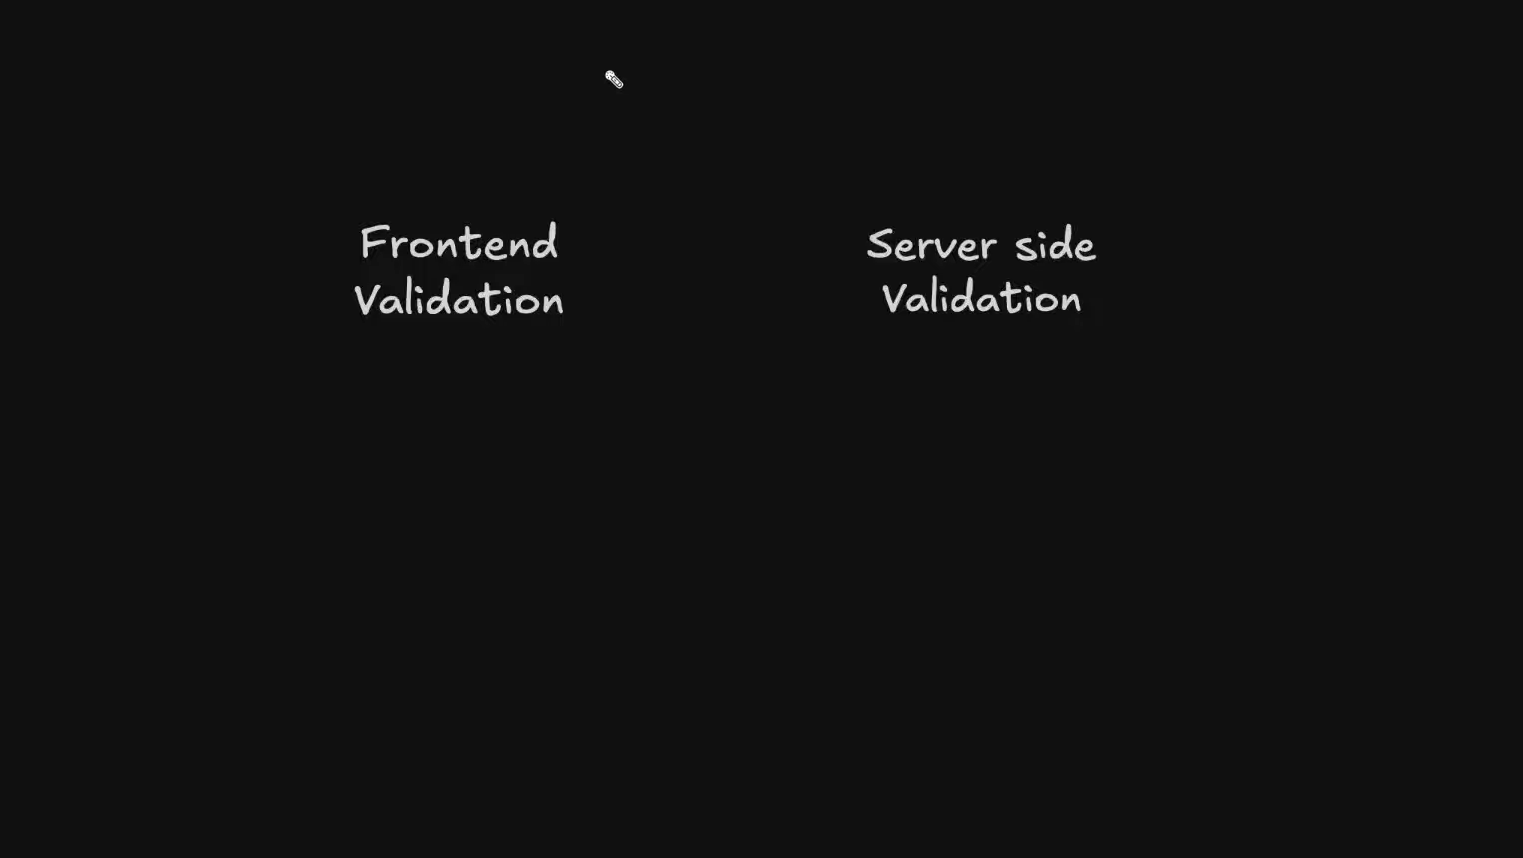

# poeple some time replace frontend validation with backend validation

in typical forms, we do some validations

the point is fronetnd validations are for user experience , its not about security
only backend valdiations are for security and data integrity.. so we need both of these for each api

Correct idea. Now I’ll tighten it so it’s **technically precise** and remove the sloppy parts.

---

## Frontend vs Backend validation — the **correct** model

### Key rule (non-negotiable)

> **Frontend validation is optional. Backend validation is mandatory.**

Anyone who says otherwise doesn’t understand security.

---

## 1️⃣ Frontend validation — UX only

### What frontend validation is for

* Faster feedback
* Better user experience
* Fewer unnecessary requests
* Guidance (required fields, formats)

### What it is NOT for

* ❌ Security
* ❌ Trust boundary
* ❌ Data integrity
* ❌ Access control

### Why it can never be trusted

* JS can be disabled
* Requests can be forged (curl, Postman)
* Frontend code can be modified
* Mobile apps can be reverse-engineered

Example:

```js
if (!email.includes("@")) {
  showError("Invalid email")
}
```

This protects **nothing**.

---

## 2️⃣ Backend validation — security & correctness

### What backend validation guarantees

* Data integrity
* Type safety
* Business invariants
* Protection against malformed or malicious input

### Backend is the **trust boundary**

Everything outside it is hostile.

Example:

```http
POST /signup
{ "email": "not-an-email" }
```

If backend accepts this → **your system is broken**.

---

## Correct validation responsibility split

| Concern               | Frontend | Backend |
| --------------------- | -------- | ------- |
| Required fields       | ✅        | ✅       |
| Type checking         | ⚠️       | ✅       |
| Length limits         | ⚠️       | ✅       |
| Format (email, phone) | ⚠️       | ✅       |
| Authorization         | ❌        | ✅       |
| Business rules        | ❌        | ✅       |
| Security constraints  | ❌        | ✅       |

Frontend can *mirror* backend rules, but backend rules must exist independently.

---

## Why replacing backend validation is dangerous

If you rely on frontend validation:

* Attackers bypass it
* Bad data enters DB
* Invariants break
* Bugs turn into exploits

This is how:

* SQL injections happen
* XSS gets stored
* Logic bugs leak data

---

## Correct mental model

```
Frontend validation = user assistance
Backend validation  = system safety
```

They are **not substitutes**.
They solve **different problems**.

---

## Ideal architecture (production-grade)

1. Frontend validates for UX
2. Backend validates again (authoritative)
3. Backend transforms data
4. Backend applies business logic

If step 2 is missing → system is insecure.

---

## One brutal sentence (remember this)

> **Frontend validation is a convenience. Backend validation is a requirement.**

You’re right to insist on both — that’s how real systems are built.
